In [5]:
# -*- coding: utf-8 -*-
### RUN IN PYTHON 3
import os
import cv2
import csv
import glob
import click
import logging
import numpy as np
import pandas as pd

from PIL import Image 
from tqdm import tqdm
from dotenv import find_dotenv, load_dotenv
from sklearn import preprocessing
from sklearn.decomposition import PCA

from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.spatial.transform import Rotation as R
from scipy.ndimage.interpolation import map_coordinates

data_dir = '/home/user/Robotics/Data_sets/slip_detection/will_dataset/data_collection_200/data_collection_001/'
out_dir = '/home/user/Robotics/Data_sets/slip_detection/manual_slip_detection/'
SAVE_IMAGES= True
sequence_length = 20
image_height, image_width = 32, 32
save_deriv1 = True
save_deriv2 = True

In [6]:
## Load the data:
files = glob.glob(data_dir + '/*')
path_file = []
index_to_save = 0

xela_sensor1_data_x_final, xela_sensor1_data_y_final, xela_sensor1_data_z_final = [], [], []
xela_sensor1_data_x_final_1stderiv = []
xela_sensor1_data_y_final_1stderiv = []
xela_sensor1_data_z_final_1stderiv = []
xela_sensor1_data_x_final_2stderiv = []
xela_sensor1_data_y_final_2stderiv = []
xela_sensor1_data_z_final_2stderiv = []


ee_positions_final = []
ee_position_x_final = []
ee_position_y_final = []
ee_position_z_final = []
ee_orientation_quat_x_final = []
ee_orientation_quat_y_final = []
ee_orientation_quat_z_final = []
ee_orientation_quat_w_final = []
ee_orientation_x_final = []
ee_orientation_y_final = []
ee_orientation_z_final = []

exp_break_points = []
exp_break_point = 0
cut = 0
for experiment_number in tqdm(range(len(files))):
    meta_data = np.asarray(pd.read_csv(files[experiment_number] + '/meta_data.csv', header=None))
    robot_state  = np.asarray(pd.read_csv(files[experiment_number] + '/robot_state.csv', header=None))
    proximity    = np.asarray(pd.read_csv(files[experiment_number] + '/proximity.csv', header=None))
    xela_sensor1 = np.asarray(pd.read_csv(files[experiment_number] + '/xela_sensor1.csv', header=None))
    xela_sensor2 = np.asarray(pd.read_csv(files[experiment_number] + '/xela_sensor2.csv', header=None))
    
    ee_positions = []
    ee_position_x, ee_position_y, ee_position_z = [], [], []
    ee_orientation_x, ee_orientation_y, ee_orientation_z = [], [], []
    ee_orientation_quat_x, ee_orientation_quat_y, ee_orientation_quat_z, ee_orientation_quat_w = [], [], [], []

    xela_sensor1_data_x, xela_sensor1_data_y, xela_sensor1_data_z = [], [], []
    xela_sensor2_data_x, xela_sensor2_data_y, xela_sensor2_data_z = [], [], []
    xela_sensor1_data_x_mean, xela_sensor1_data_y_mean, xela_sensor1_data_z_mean = [], [], []
    xela_sensor2_data_x_mean, xela_sensor2_data_y_mean, xela_sensor2_data_z_mean = [], [], []
    
    ####################################### Robot Data ###########################################
    for state in robot_state[1:]:
        ee_positions.append([float(item) for item in robot_state[1][-7:-4]])
        ee_position_x.append(state[-7])
        ee_position_y.append(state[-6])
        ee_position_z.append(state[-5])
        # quat
        ee_orientation_quat_x.append(state[-4])
        ee_orientation_quat_y.append(state[-3])
        ee_orientation_quat_z.append(state[-2])
        ee_orientation_quat_w.append(state[-1])
        # euler
        ee_orientation = R.from_quat([state[-4], state[-3], state[-2], state[-1]]).as_euler('zyx', degrees=True)
        ee_orientation_x.append(ee_orientation[0])
        ee_orientation_y.append(ee_orientation[1])
        ee_orientation_z.append(ee_orientation[2])
        exp_break_point += 1

    # fix the euler angles:
    for i in range(len(ee_orientation_z)):
        if ee_orientation_z[i] < 0:
            ee_orientation_z[i] += 360

    ####################################### Xela Data ###########################################
    for sample1, sample2 in zip(xela_sensor1[1:], xela_sensor2[1:]):
        sample1_data_x, sample1_data_y, sample1_data_z = [], [], []
        sample2_data_x, sample2_data_y, sample2_data_z = [], [], []
        for i in range(0, len(xela_sensor1[0]), 3):
            sample1_data_x.append(float(sample1[i]))
            sample1_data_y.append(float(sample1[i+1]))
            sample1_data_z.append(float(sample1[i+2]))
        xela_sensor1_data_x.append(sample1_data_x)
        xela_sensor1_data_y.append(sample1_data_y)
        xela_sensor1_data_z.append(sample1_data_z)

    # mean starting values:
    xela_sensor1_average_starting_value_x = int(sum(xela_sensor1_data_x[0]) / len(xela_sensor1_data_x[0]))
    xela_sensor1_average_starting_value_y = int(sum(xela_sensor1_data_y[0]) / len(xela_sensor1_data_y[0]))
    xela_sensor1_average_starting_value_z = int(sum(xela_sensor1_data_z[0]) / len(xela_sensor1_data_z[0]))
    xela_sensor1_offset_x = [xela_sensor1_average_starting_value_x - tactile_starting_value for tactile_starting_value in xela_sensor1_data_x[0]]
    xela_sensor1_offset_y = [xela_sensor1_average_starting_value_y - tactile_starting_value for tactile_starting_value in xela_sensor1_data_y[0]]
    xela_sensor1_offset_z = [xela_sensor1_average_starting_value_z - tactile_starting_value for tactile_starting_value in xela_sensor1_data_z[0]]
    
    for time_step in range(len(xela_sensor1_data_x)):
        xela_sensor1_sample_x_test = [offset+real_value for offset, real_value in zip(xela_sensor1_offset_x, xela_sensor1_data_x[time_step])]
        xela_sensor1_sample_y_test = [offset+real_value for offset, real_value in zip(xela_sensor1_offset_y, xela_sensor1_data_y[time_step])]
        xela_sensor1_sample_z_test = [offset+real_value for offset, real_value in zip(xela_sensor1_offset_z, xela_sensor1_data_z[time_step])]
        for i in range(np.asarray(xela_sensor1_data_x).shape[1]):
            xela_sensor1_data_x[time_step][i] = xela_sensor1_sample_x_test[i]
            xela_sensor1_data_y[time_step][i] = xela_sensor1_sample_y_test[i] 
            xela_sensor1_data_z[time_step][i] = xela_sensor1_sample_z_test[i]
    
    # calculate the derivatives
    if save_deriv1 == True:
        cut = 1
        xela_deriv1_x = np.diff(np.array(xela_sensor1_data_x), axis=0).tolist()
        xela_deriv1_y = np.diff(np.array(xela_sensor1_data_y), axis=0).tolist()
        xela_deriv1_z = np.diff(np.array(xela_sensor1_data_z), axis=0).tolist()
        # store the data:
        xela_sensor1_data_x_final_1stderiv += xela_deriv1_x 
        xela_sensor1_data_y_final_1stderiv += xela_deriv1_y 
        xela_sensor1_data_z_final_1stderiv += xela_deriv1_z 
        
    if save_deriv2 == True:
        cut = 2
        xela1_deriv2_x = np.diff(np.array(xela_sensor1_data_x), axis=0, n=2).tolist()
        xela1_deriv2_y = np.diff(np.array(xela_sensor1_data_y), axis=0, n=2).tolist()
        xela1_deriv2_z = np.diff(np.array(xela_sensor1_data_z), axis=0, n=2).tolist()
        # store the data:
        xela_sensor1_data_x_final_2stderiv += xela1_deriv2_x 
        xela_sensor1_data_y_final_2stderiv += xela1_deriv2_y 
        xela_sensor1_data_z_final_2stderiv += xela1_deriv2_z        
        
    xela_sensor1_data_x_final += xela_sensor1_data_x[cut:]
    xela_sensor1_data_y_final += xela_sensor1_data_y[cut:]
    xela_sensor1_data_z_final += xela_sensor1_data_z[cut:]
    ee_positions_final += ee_positions[cut:]
    ee_position_x_final += ee_position_x[cut:]
    ee_position_y_final += ee_position_y[cut:]
    ee_position_z_final += ee_position_z[cut:]
    ee_orientation_quat_x_final += ee_orientation_quat_x[cut:]
    ee_orientation_quat_y_final += ee_orientation_quat_y[cut:]
    ee_orientation_quat_z_final += ee_orientation_quat_z[cut:]
    ee_orientation_quat_w_final += ee_orientation_quat_w[cut:]
    ee_orientation_x_final += ee_orientation_x[cut:]
    ee_orientation_y_final += ee_orientation_y[cut:]
    ee_orientation_z_final += ee_orientation_z[cut:]

    exp_break_points.append(exp_break_point - cut)

100%|██████████| 218/218 [02:16<00:00,  1.60it/s]


In [7]:
xela_sensor1_data_x_final = np.asarray(xela_sensor1_data_x_final)
xela_sensor1_data_y_final = np.asarray(xela_sensor1_data_y_final)
xela_sensor1_data_z_final = np.asarray(xela_sensor1_data_z_final)

scale_together = False
if scale_together == True:
    xela_sensor1_data = np.concatenate((xela_sensor1_data_x_final, xela_sensor1_data_y_final, xela_sensor1_data_z_final), axis=1)
    scaler_full = preprocessing.StandardScaler().fit(xela_sensor1_data)
    xela_sensor1_data_scaled = scaler_full.transform(xela_sensor1_data)
    min_max_scaler_full_data = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(xela_sensor1_data_scaled)
    xela_sensor1_data_scaled_minmax = min_max_scaler_full_data.transform(xela_sensor1_data_scaled)

elif scale_together == False:
    scaler_tx = preprocessing.StandardScaler().fit(xela_sensor1_data_x_final)
    scaler_ty = preprocessing.StandardScaler().fit(xela_sensor1_data_y_final)
    scaler_tz = preprocessing.StandardScaler().fit(xela_sensor1_data_z_final)
    xelax_sensor1_data_scaled = scaler_tx.transform(xela_sensor1_data_x_final)
    xelay_sensor1_data_scaled = scaler_ty.transform(xela_sensor1_data_y_final)
    xelaz_sensor1_data_scaled = scaler_tz.transform(xela_sensor1_data_z_final)
    xela_sensor1_data_scaled = np.concatenate((xelax_sensor1_data_scaled,
                                               xelay_sensor1_data_scaled,
                                               xelaz_sensor1_data_scaled), axis=1)
    
    min_max_scalerx_full_data = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(xelax_sensor1_data_scaled)
    min_max_scalery_full_data = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(xelay_sensor1_data_scaled)
    min_max_scalerz_full_data = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(xelaz_sensor1_data_scaled)    
    xelax_sensor1_data_scaled_minmax = min_max_scalerx_full_data.transform(xelax_sensor1_data_scaled)
    xelay_sensor1_data_scaled_minmax = min_max_scalery_full_data.transform(xelay_sensor1_data_scaled)
    xelaz_sensor1_data_scaled_minmax = min_max_scalerz_full_data.transform(xelaz_sensor1_data_scaled)

    xela_sensor1_data_scaled_minmax = np.concatenate((xelax_sensor1_data_scaled_minmax,
                                        xelay_sensor1_data_scaled_minmax,
                                        xelaz_sensor1_data_scaled_minmax), axis=1)
    
if save_deriv1 == True:
    scaler_td1x = preprocessing.StandardScaler().fit(xela_sensor1_data_x_final_1stderiv)
    scaler_td1y = preprocessing.StandardScaler().fit(xela_sensor1_data_y_final_1stderiv)
    scaler_td1z = preprocessing.StandardScaler().fit(xela_sensor1_data_z_final_1stderiv)
    xelax_sensor1d1_data_scaled = scaler_td1x.transform(xela_sensor1_data_x_final_1stderiv)
    xelay_sensor1d1_data_scaled = scaler_td1y.transform(xela_sensor1_data_y_final_1stderiv)
    xelaz_sensor1d1_data_scaled = scaler_td1z.transform(xela_sensor1_data_z_final_1stderiv)
    xelad1_sensor1_data_scaled = np.concatenate((xelax_sensor1d1_data_scaled,
                                               xelay_sensor1d1_data_scaled,
                                               xelaz_sensor1d1_data_scaled), axis=1)
    
    min_max_scalerd1x_full_data = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(xelax_sensor1d1_data_scaled)
    min_max_scalerd1y_full_data = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(xelay_sensor1d1_data_scaled)
    min_max_scalerd1z_full_data = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(xelaz_sensor1d1_data_scaled)    
    xelad1x_sensor1_data_scaled_minmax = min_max_scalerd1x_full_data.transform(xelax_sensor1d1_data_scaled)
    xelad1y_sensor1_data_scaled_minmax = min_max_scalerd1y_full_data.transform(xelay_sensor1d1_data_scaled)
    xelad1z_sensor1_data_scaled_minmax = min_max_scalerd1z_full_data.transform(xelaz_sensor1d1_data_scaled)

    xelad1_sensor1_data_scaled_minmax = np.concatenate((xelad1x_sensor1_data_scaled_minmax,
                                        xelad1y_sensor1_data_scaled_minmax,
                                        xelad1z_sensor1_data_scaled_minmax), axis=1)

if save_deriv2 == True:
    scaler_td2x = preprocessing.StandardScaler().fit(xela_sensor1_data_x_final_2stderiv)
    scaler_td2y = preprocessing.StandardScaler().fit(xela_sensor1_data_y_final_2stderiv)
    scaler_td2z = preprocessing.StandardScaler().fit(xela_sensor1_data_z_final_2stderiv)
    xelax_sensor1d2_data_scaled = scaler_td2x.transform(xela_sensor1_data_x_final_2stderiv)
    xelay_sensor1d2_data_scaled = scaler_td2y.transform(xela_sensor1_data_y_final_2stderiv)
    xelaz_sensor1d2_data_scaled = scaler_td2z.transform(xela_sensor1_data_z_final_2stderiv)
    xelad2_sensor1_data_scaled = np.concatenate((xelax_sensor1d2_data_scaled,
                                               xelay_sensor1d2_data_scaled,
                                               xelaz_sensor1d2_data_scaled), axis=1)
    
    min_max_scalerd2x_full_data = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(xelax_sensor1d2_data_scaled)
    min_max_scalerd2y_full_data = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(xelay_sensor1d2_data_scaled)
    min_max_scalerd2z_full_data = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(xelaz_sensor1d2_data_scaled)    
    xelad2x_sensor1_data_scaled_minmax = min_max_scalerd2x_full_data.transform(xelax_sensor1d2_data_scaled)
    xelad2y_sensor1_data_scaled_minmax = min_max_scalerd2y_full_data.transform(xelay_sensor1d2_data_scaled)
    xelad2z_sensor1_data_scaled_minmax = min_max_scalerd2z_full_data.transform(xelaz_sensor1d2_data_scaled)

    xelad2_sensor1_data_scaled_minmax = np.concatenate((xelad2x_sensor1_data_scaled_minmax,
                                        xelad2y_sensor1_data_scaled_minmax,
                                        xelad2z_sensor1_data_scaled_minmax), axis=1)


In [8]:
# -*- coding: utf-8 -*-
import csv
import tqdm
import copy
import click
import logging
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset

from string import digits

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F

seed = 42
epochs = 100
batch_size = 32
learning_rate = 1e-3
context_frames = 10
sequence_length = 20
lookback = sequence_length

valid_train_split = 0.85  # precentage of train data from total
test_train_split = 0.95  # precentage of train data from total

torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")#  use gpu if available
################################# CHANGE THIS!!!!  #################################
model_path = "/home/user/Robotics/slip_detection_model/slip_detection_model/manual_data_models/models/simple_model_003/"
################################# CHANGE THIS!!!!  #################################

In [9]:
# scale between 0 and 1:
ee_position_x_final = np.array(ee_position_x_final) 
ee_position_y_final = np.array(ee_position_y_final) 
ee_position_z_final = np.array(ee_position_z_final) 
ee_orientation_quat_x_final = np.array(ee_orientation_quat_x_final).reshape(-1, 1)
ee_orientation_quat_y_final = np.array(ee_orientation_quat_y_final).reshape(-1, 1)
ee_orientation_quat_z_final = np.array(ee_orientation_quat_z_final).reshape(-1, 1)
ee_orientation_quat_w_final = np.array(ee_orientation_quat_w_final).reshape(-1, 1)
ee_orientation_x_final = np.array(ee_orientation_x_final)
ee_orientation_y_final = np.array(ee_orientation_y_final)
ee_orientation_z_final = np.array(ee_orientation_z_final)
# xela_sensor1_principle_components = np.array(xela_sensor1_principle_components) 
xela_sensor1_principle_components =  np.array(xela_sensor1_data_scaled)
if save_deriv1 == True:
    xelad1_sensor1_data_scaled_minmax = np.array(xelad1_sensor1_data_scaled_minmax)
if save_deriv2 == True:
    xelad2_sensor1_data_scaled_minmax = np.array(xelad2_sensor1_data_scaled_minmax)

min_max_scaler_ee_position_x_final = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(ee_position_x_final.reshape(-1, 1))
ee_position_x_final_scaled = min_max_scaler_ee_position_x_final.transform(ee_position_x_final.reshape(-1, 1))

min_max_scaler_ee_position_y_final = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(ee_position_y_final.reshape(-1, 1))
ee_position_y_final_scaled = min_max_scaler_ee_position_y_final.transform(ee_position_y_final.reshape(-1, 1))

min_max_scaler_ee_position_z_final = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(ee_position_z_final.reshape(-1, 1))
ee_position_z_final_scaled = min_max_scaler_ee_position_z_final.transform(ee_position_z_final.reshape(-1, 1))

min_max_scaler_ee_orientation_quat_x_final = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(ee_orientation_quat_x_final)
ee_orientation_quat_x_final_scaled = min_max_scaler_ee_orientation_quat_x_final.transform(ee_orientation_quat_x_final)

min_max_scaler_ee_orientation_quat_y_final = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(ee_orientation_quat_y_final)
ee_orientation_quat_y_final_scaled = min_max_scaler_ee_orientation_quat_y_final.transform(ee_orientation_quat_y_final)

min_max_scaler_ee_orientation_quat_z_final = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(ee_orientation_quat_z_final)
ee_orientation_quat_z_final_scaled = min_max_scaler_ee_orientation_quat_z_final.transform(ee_orientation_quat_z_final)

min_max_scaler_ee_orientation_quat_w_final = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(ee_orientation_quat_w_final)
ee_orientation_quat_w_final_scaled = min_max_scaler_ee_orientation_quat_w_final.transform(ee_orientation_quat_w_final)

min_max_scaler_ee_orientation_x_final = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(ee_orientation_x_final.reshape(-1, 1))
ee_orientation_x_final_scaled = min_max_scaler_ee_orientation_x_final.transform(ee_orientation_x_final.reshape(-1, 1))

min_max_scaler_ee_orientation_y_final = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(ee_orientation_y_final.reshape(-1, 1))
ee_orientation_y_final_scaled = min_max_scaler_ee_orientation_y_final.transform(ee_orientation_y_final.reshape(-1, 1))

min_max_scaler_ee_orientation_z_final = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(ee_orientation_z_final.reshape(-1, 1))
ee_orientation_z_final_scaled = min_max_scaler_ee_orientation_z_final.transform(ee_orientation_z_final.reshape(-1, 1))

if scale_together == True:
    min_max_scaler_xela_sensor1_principle_components = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(xela_sensor1_principle_components)
    xela_sensor1_principle_components_scaled = min_max_scaler_xela_sensor1_principle_components.transform(xela_sensor1_principle_components)
else:
    xela_sensor1_principle_components_scaled = xela_sensor1_data_scaled_minmax

if save_deriv1 == True:
    xelad1_sensor1_principle_components_scaled = xelad1_sensor1_data_scaled_minmax
if save_deriv2 == True:
    xelad2_sensor1_principle_components_scaled = xelad2_sensor1_data_scaled_minmax

# Convert data back into split experiments to create the sequences:
ee_position_x_final_split = np.asarray(np.split(ee_position_x_final_scaled, exp_break_points)[0:-1])
ee_position_y_final_split = np.asarray(np.split(ee_position_y_final_scaled, exp_break_points)[0:-1])
ee_position_z_final_split = np.asarray(np.split(ee_position_z_final_scaled, exp_break_points)[0:-1])
ee_orientation_quat_x_final_split = np.asarray(np.split(ee_orientation_quat_x_final_scaled, exp_break_points)[0:-1])
ee_orientation_quat_y_final_split = np.asarray(np.split(ee_orientation_quat_y_final_scaled, exp_break_points)[0:-1])
ee_orientation_quat_z_final_split = np.asarray(np.split(ee_orientation_quat_z_final_scaled, exp_break_points)[0:-1])
ee_orientation_quat_w_final_split = np.asarray(np.split(ee_orientation_quat_w_final_scaled, exp_break_points)[0:-1])
ee_orientation_x_final_split = np.asarray(np.split(ee_orientation_x_final_scaled, exp_break_points)[0:-1])
ee_orientation_y_final_split = np.asarray(np.split(ee_orientation_y_final_scaled, exp_break_points)[0:-1])
ee_orientation_z_final_split = np.asarray(np.split(ee_orientation_z_final_scaled, exp_break_points)[0:-1])
xela_sensor1_principle_components_split = np.asarray(np.split(xela_sensor1_principle_components_scaled, exp_break_points)[0:-1])
if save_deriv1 == True:
    xela_sensor1_data_1stderiv_scaled_split = np.asarray(np.split(xelad1_sensor1_principle_components_scaled, exp_break_points)[0:-1])
if save_deriv2 == True:
    xela_sensor1_data_2stderiv_scaled_split = np.asarray(np.split(xelad2_sensor1_principle_components_scaled, exp_break_points)[0:-1])

# for cut_at in to_cut_list:
#     ee_position_x_final_split[experiment] = ee_position_x_final_split[experiment][cut_at:] 
#     ee_position_y_final_split[experiment] = ee_position_y_final_split[experiment][cut_at:] 
#     ee_position_z_final_split[experiment] = ee_position_z_final_split[experiment][cut_at:] 
#     ee_orientation_quat_x_final_split[experiment] = ee_orientation_quat_x_final_split[experiment][cut_at:] 
#     ee_orientation_quat_y_final_split[experiment] = ee_orientation_quat_y_final_split[experiment][cut_at:] 
#     ee_orientation_quat_z_final_split[experiment] = ee_orientation_quat_z_final_split[experiment][cut_at:] 
#     ee_orientation_quat_w_final_split[experiment] = ee_orientation_quat_w_final_split[experiment][cut_at:] 
#     ee_orientation_x_final_split[experiment] = ee_orientation_x_final_split[experiment][cut_at:] 
#     ee_orientation_y_final_split[experiment] = ee_orientation_y_final_split[experiment][cut_at:] 
#     ee_orientation_z_final_split[experiment] = ee_orientation_z_final_split[experiment][cut_at:] 
#     xela_sensor1_principle_components_split[experiment] = xela_sensor1_principle_components_split[experiment][cut_at:] 
# print(xela_sensor1_principle_components_split.shape)
# print(ee_orientation_z_final_split.shape)

# Shuffle data:
p = np.random.permutation(len(ee_position_x_final_split))
p = np.delete(p, np.where(p==106))  # make 106 always in the test set (for comparing graphs)
p = np.append(p, [106])
print("shuffle order: ", p)
ee_position_x_final_split = ee_position_x_final_split[p]
ee_position_y_final_split = ee_position_y_final_split[p]
ee_position_z_final_split = ee_position_z_final_split[p]
ee_orientation_quat_x_final_split = ee_orientation_quat_x_final_split[p]
ee_orientation_quat_y_final_split = ee_orientation_quat_y_final_split[p]
ee_orientation_quat_z_final_split = ee_orientation_quat_z_final_split[p]
ee_orientation_quat_w_final_split = ee_orientation_quat_w_final_split[p]
ee_orientation_x_final_split = ee_orientation_x_final_split[p]
ee_orientation_y_final_split = ee_orientation_y_final_split[p]
ee_orientation_z_final_split = ee_orientation_z_final_split[p]
xela_sensor1_principle_components_split = xela_sensor1_principle_components_split[p]
xela_sensor1_data_1stderiv_scaled_split = xela_sensor1_data_1stderiv_scaled_split[p]
xela_sensor1_data_2stderiv_scaled_split = xela_sensor1_data_2stderiv_scaled_split[p]

# convert to sequences:
robot_data_euler_sequence, robot_data_quat_sequence, xela_1_sequence_data, experiment_data_sequence, time_step_data_sequence = [], [], [], [], []
xela1_1stderiv_sequence = []
xela1_2stderiv_sequence = []
for experiment in range(len(ee_position_x_final_split)):
    for sample in range(0, len(ee_position_x_final_split[experiment]) - sequence_length):
        robot_data_euler_sample, robot_data_quat_sample, xela_1_sequ_sample, experiment_data_sample, time_step_data_sample = [], [], [], [], []
        xela_sensor1_1stderiv = []
        xela_sensor1_2stderiv = []
        for t in range(0, sequence_length):
            robot_data_euler_sample.append([ee_position_x_final_split[experiment][sample+t], ee_position_y_final_split[experiment][sample+t], ee_position_z_final_split[experiment][sample+t], ee_orientation_x_final_split[experiment][sample+t], ee_orientation_y_final_split[experiment][sample+t], ee_orientation_z_final_split[experiment][sample+t]])
            robot_data_quat_sample.append([ee_position_x_final_split[experiment][sample+t], ee_position_y_final_split[experiment][sample+t], ee_position_z_final_split[experiment][sample+t], ee_orientation_quat_x_final_split[experiment][sample+t][0], ee_orientation_quat_y_final_split[experiment][sample+t][0], ee_orientation_quat_z_final_split[experiment][sample+t][0], ee_orientation_quat_w_final_split[experiment][sample+t][0]])
            xela_1_sequ_sample.append(xela_sensor1_principle_components_split[experiment][sample+t])
            xela_sensor1_1stderiv.append(xela_sensor1_data_1stderiv_scaled_split[experiment][sample+t])
            xela_sensor1_2stderiv.append(xela_sensor1_data_2stderiv_scaled_split[experiment][sample+t])
            experiment_data_sample.append(experiment)
            time_step_data_sample.append(sample+t)
        robot_data_euler_sequence.append(robot_data_euler_sample)
        robot_data_quat_sequence.append(robot_data_quat_sample)
        xela_1_sequence_data.append(xela_1_sequ_sample)
        xela1_1stderiv_sequence.append(xela_sensor1_1stderiv)
        xela1_2stderiv_sequence.append(xela_sensor1_2stderiv)
        experiment_data_sequence.append(experiment_data_sample)
        time_step_data_sequence.append(time_step_data_sample)

shuffle order:  [ 67 130  42  88 162  37  40  45  86  30  71  59  49  65 200   8  58  66
  63 206 123 194  94 192  33 179 205 159 117 168 185  91  62  72 169 176
 207 105  90 142 120 210   2  15  31 115 131 146 208 160 138 137  13  95
 150 164 216  57  82 209 103 217   3 143  46 191 199 178  50  97  81 116
 177 136   6 104 145 154 128  68 173  73 149 124  99 153 195 129 161 114
  93 203  84 166 152  70  18  85 181  75 204  11 125   5 163 212   7 132
 139 174 135 107 175  98  21 215  22  16 121  24 201  51  27  54 182  10
  23 112 167  44 108 119 155  83  77 197  17 158  19 111 151 134  39  20
 184  32 190 100  28  96  55 109  29  35  79  34  60 122   4  26  76 118
  38 165  69 183 193  89   0  74 110 141  14 188 156   1  25 144  87  61
 189 102  92 101 140  80 157 187  48 126 213 170 214 198  52  43 211 127
 148  12  78  36 202 113 147 133  53  47   9 180  41  64  56 171 196 172
 186 106]


In [16]:
class BatchGenerator:
    def __init__(self):
        pass

    def load_full_data(self):
        dataset_train = FullDataSet(type_="train")
        dataset_valid = FullDataSet(type_="valid")
        dataset_test = FullDataSet(type_="test")
        transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
        train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, pin_memory=True)
        valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=True, pin_memory=True)
        test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False)
        return train_loader, valid_loader, test_loader

class FullDataSet():
    def __init__(self, type_="train"):
        if type_ == "train":
            self.samples = [0, int(len(robot_data_euler_sequence)*test_train_split)]
        elif type_ == "valid":
            self.samples = [int(len(robot_data_euler_sequence)*(valid_train_split)), int(len(robot_data_euler_sequence)*test_train_split)]
        elif type_ == "test":
            self.samples = [int(len(robot_data_euler_sequence)*test_train_split), len(robot_data_euler_sequence)]

    def __len__(self):
        return self.samples[1] - self.samples[0]

    def __getitem__(self,idx):
        robot_euler = robot_data_euler_sequence[self.samples[0] + idx]
        tactile_deriv1 = xela1_1stderiv_sequence[self.samples[0] + idx]
        tactile_deriv2 = xela1_2stderiv_sequence[self.samples[0] + idx]
        xela1 = xela_1_sequence_data[self.samples[0] + idx]
        experiment = experiment_data_sequence[self.samples[0] + idx]
        time_step  = time_step_data_sequence[self.samples[0] + idx]
        return([np.array(robot_euler).astype(np.float32),
                np.array(xela1).astype(np.float32),
                np.array(tactile_deriv1).astype(np.float32),
                np.array(tactile_deriv2).astype(np.float32),
                np.array(experiment),
                np.array(time_step)])

In [30]:
# single LSTM attempt
class FullModel(nn.Module):
    def __init__(self):
        super(FullModel, self).__init__()
        self.lstm1 = nn.LSTM(48 + 48 + 48, 200).to(device)  # tactile
        self.lstm2 = nn.LSTM(200, 200).to(device)  # tactile
        self.fc1 = nn.Linear(200 + 48 + 48, 200).to(device)  # tactile + pos_vel
        self.fc2 = nn.Linear(200, 48 + 48).to(device)  # tactile + pos_vel
        self.tan_activation = nn.Tanh().to(device)

    def forward(self, tactiles, actions, tac_deriv1, tac_deriv2):
        state = actions[0]
        state.to(device)
        batch_size__ = tactiles.shape[1]
        outputs = []
        hidden1 = (torch.zeros(1,batch_size__,200, device=torch.device('cuda')), torch.zeros(1,batch_size__,200, device=torch.device('cuda')))
        hidden2 = (torch.zeros(1,batch_size__,200, device=torch.device('cuda')), torch.zeros(1,batch_size__,200, device=torch.device('cuda')))

        for index, (sample_tactile, sample_action, sample_tactilederiv1, sample_tactilederiv1) in enumerate(zip(tactiles.squeeze(), actions.squeeze(), tac_deriv1.squeeze(), tac_deriv2.squeeze()), ):
            # 2. Run through lstm:
            if index > context_frames-1:
                out4 = out4 .squeeze()
                tiled_action_and_state = torch.cat((sample_action, state, sample_action, state,
                                                   sample_action, state, sample_action, state), 1)                
                action_and_tactile = torch.cat((out4, tiled_action_and_state), 1)
                out1, hidden1 = self.lstm1(action_and_tactile.unsqueeze(0), hidden1)
                out2, hidden2 = self.lstm2(out1, hidden2)
                lstm_and_prev_tactile = torch.cat((out2.squeeze(), out4), 1)
                out3 = self.tan_activation(self.fc1(lstm_and_prev_tactile))
                out4 = self.tan_activation(self.fc2(out3))
                outputs.append(out4.squeeze())
            else:
                tiled_action_and_state = torch.cat((sample_action, state, sample_action, state,
                                                   sample_action, state, sample_action, state), 1)                
                action_and_tactile = torch.cat((sample_tactile, tiled_action_and_state, sample_tactilederiv1), 1)                
                out1, hidden1 = self.lstm1(action_and_tactile.unsqueeze(0), hidden1)
                out2, hidden2 = self.lstm2(out1, hidden2)
                lstm_and_prev_tactile = torch.cat((out2.squeeze(), sample_tactile, sample_tactilederiv1), 1)
                out3 = self.tan_activation(self.fc1(lstm_and_prev_tactile))
                out4 = self.tan_activation(self.fc2(out3))

        return torch.stack(outputs)

In [31]:
class ModelTrainer:
    def __init__(self):
        self.train_full_loader, self.valid_full_loader, self.test_full_loader = BG.load_full_data()
        self.full_model = FullModel()
        self.criterion = nn.L1Loss()
        self.criterion1 = nn.L1Loss()
        self.optimizer = optim.Adam(self.full_model.parameters(), lr=learning_rate)

    def train_full_model(self):
        plot_training_loss = []
        plot_validation_loss = []
        previous_val_mean_loss = 100.0
        best_val_loss = 100.0
        early_stop_clock = 0
        progress_bar = tqdm.tqdm(range(0, epochs), total=(epochs*len(self.train_full_loader)))
        mean_test = 0
        for epoch in progress_bar:
            loss = 0.0
            losses = 0.0
            for index, batch_features in enumerate(self.train_full_loader):
                action = batch_features[0].squeeze().permute(1,0,2).to(device)
                tactile = batch_features[1].permute(1,0,2).to(device)
                tactilederiv1 = batch_features[2].permute(1,0,2).to(device)
                tactilederiv2 = batch_features[3].permute(1,0,2).to(device)
                tactile_predictions = self.full_model.forward(tactiles=tactile, actions=action, tac_deriv1=tactilederiv1, tac_deriv2=tactilederiv2) # Step 3. Run our forward pass.
                self.optimizer.zero_grad()
                if save_deriv1 == True:
                    ground_truth = torch.cat((tactile[context_frames:],tactilederiv1[context_frames:]), 2)
                else:
                    ground_truth = tactile[context_frames:]
                loss = self.criterion(tactile_predictions, ground_truth)
                loss.backward()
                self.optimizer.step()

                losses += loss.item()
                if index:
                    mean = losses / index
                else:
                    mean = 0
                progress_bar.set_description("epoch: {}, ".format(epoch) + "loss: {:.4f}, ".format(float(loss.item())) + "mean loss: {:.4f}, ".format(mean))
                progress_bar.update()
            plot_training_loss.append(mean)

            val_losses = 0.0
            val_loss = 0.0
            with torch.no_grad():
                for index__, batch_features in enumerate(self.valid_full_loader):
                    action = batch_features[0].squeeze().permute(1,0,2).to(device)
                    tactile = batch_features[1].permute(1,0,2).to(device)
                    tactilederiv1 = batch_features[2].permute(1,0,2).to(device)
                    tactilederiv2 = batch_features[3].permute(1,0,2).to(device)
                    tactile_predictions = self.full_model.forward(tactiles=tactile, actions=action, tac_deriv1=tactilederiv1, tac_deriv2=tactilederiv2) # Step 3. Run our forward pass.                    
                    if save_deriv1 == True:
                        ground_truth = torch.cat((tactile[context_frames:],tactilederiv1[context_frames:]), 2)
                    else:
                        ground_truth = tactile[context_frames:]
                    self.optimizer.zero_grad()
                    val_loss = self.criterion(tactile_predictions[:,:,:48].to(device), ground_truth[:,:,:48])
                    val_losses += val_loss.item()

            print("Validation mean loss: {:.4f}, ".format(val_losses / index__))
            plot_validation_loss.append(val_losses / index__)
            if previous_val_mean_loss < val_losses / index__:
                early_stop_clock +=1
                previous_val_mean_loss = val_losses / index__ 
                if early_stop_clock == 3:
                    print("Early stopping")
                    break
            else:
                if best_val_loss > val_losses / index__:
                    print("saving model")
                    torch.save(self.full_model, model_path + "trained_model")
                    self.strongest_model = copy.deepcopy(self.full_model)
                early_stop_clock = 0
                previous_val_mean_loss = val_losses / index__ 
        plt.plot(plot_training_loss, c="r", label="train loss MAE")
        plt.plot(plot_validation_loss, c='b', label="val loss MAE")
        plt.legend(loc="upper right")
        plt.savefig(model_path + '/trining_plot.png', dpi=300)
        plt.show()
        np.save(model_path + 'training_loss', np.asarray(plot_training_loss))
        np.save(model_path + 'validation_loss', np.asarray(plot_validation_loss))

epoch: 1, loss: 0.0157, mean loss: 0.0179, :   1%|          | 5051/504600 [02:36<52:34:46,  2.64it/s]

Validation mean loss: 0.0209, 
saving model


epoch: 2, loss: 0.0124, mean loss: 0.0126, :   2%|▏         | 10097/504600 [05:13<72:33:59,  1.89it/s]

Validation mean loss: 0.0174, 
saving model


epoch: 3, loss: 0.0098, mean loss: 0.0123, :   3%|▎         | 15143/504600 [07:50<53:24:10,  2.55it/s]

Validation mean loss: 0.0160, 
saving model


epoch: 4, loss: 0.0093, mean loss: 0.0114, :   4%|▍         | 20192/504600 [10:22<54:08:44,  2.49it/s]

Validation mean loss: 0.0149, 
saving model


epoch: 5, loss: 0.0109, mean loss: 0.0127, :   5%|▌         | 25239/504600 [12:53<50:17:35,  2.65it/s]

Validation mean loss: 0.0146, 
saving model


epoch: 6, loss: 0.0086, mean loss: 0.0113, :   6%|▌         | 30285/504600 [15:27<69:33:29,  1.89it/s]

Validation mean loss: 0.0139, 
saving model


epoch: 7, loss: 0.0085, mean loss: 0.0103, :   7%|▋         | 35331/504600 [18:04<50:06:37,  2.60it/s]

Validation mean loss: 0.0132, 
saving model


epoch: 8, loss: 0.0070, mean loss: 0.0100, :   8%|▊         | 40377/504600 [20:40<67:02:59,  1.92it/s]

Validation mean loss: 0.0126, 
saving model


epoch: 9, loss: 0.0110, mean loss: 0.0116, :   9%|▉         | 45423/504600 [23:15<48:27:32,  2.63it/s]

Validation mean loss: 0.0131, 


epoch: 10, loss: 0.0073, mean loss: 0.0095, :  10%|█         | 50469/504600 [25:51<65:05:20,  1.94it/s]

Validation mean loss: 0.0121, 
saving model


epoch: 11, loss: 0.0072, mean loss: 0.0105, :  11%|█         | 55515/504600 [28:27<46:43:05,  2.67it/s]

Validation mean loss: 0.0120, 
saving model


epoch: 12, loss: 0.0067, mean loss: 0.0093, :  12%|█▏        | 60561/504600 [31:02<63:51:18,  1.93it/s]

Validation mean loss: 0.0118, 
saving model


epoch: 13, loss: 0.0075, mean loss: 0.0099, :  13%|█▎        | 65607/504600 [33:38<46:15:21,  2.64it/s]

Validation mean loss: 0.0114, 
saving model


epoch: 14, loss: 0.0075, mean loss: 0.0087, :  14%|█▍        | 70653/504600 [36:14<62:23:51,  1.93it/s]

Validation mean loss: 0.0117, 


epoch: 15, loss: 0.0065, mean loss: 0.0088, :  15%|█▌        | 75699/504600 [38:49<45:03:55,  2.64it/s]

Validation mean loss: 0.0113, 
saving model


epoch: 16, loss: 0.0068, mean loss: 0.0084, :  16%|█▌        | 80745/504600 [41:24<61:27:06,  1.92it/s]

Validation mean loss: 0.0114, 


epoch: 17, loss: 0.0072, mean loss: 0.0098, :  17%|█▋        | 85791/504600 [43:58<43:24:52,  2.68it/s]

Validation mean loss: 0.0109, 
saving model


epoch: 18, loss: 0.0073, mean loss: 0.0080, :  18%|█▊        | 90837/504600 [46:34<60:02:09,  1.91it/s]

Validation mean loss: 0.0108, 
saving model


epoch: 19, loss: 0.0063, mean loss: 0.0094, :  19%|█▉        | 95883/504600 [49:10<42:56:46,  2.64it/s]

Validation mean loss: 0.0108, 
saving model


epoch: 20, loss: 0.0066, mean loss: 0.0087, :  20%|██        | 100929/504600 [51:45<58:48:48,  1.91it/s]

Validation mean loss: 0.0107, 
saving model


epoch: 21, loss: 0.0078, mean loss: 0.0093, :  21%|██        | 105975/504600 [54:21<41:38:02,  2.66it/s]

Validation mean loss: 0.0105, 
saving model


epoch: 22, loss: 0.0125, mean loss: 0.0100, :  22%|██▏       | 111021/504600 [56:57<56:58:58,  1.92it/s]

Validation mean loss: 0.0108, 


epoch: 23, loss: 0.0070, mean loss: 0.0084, :  23%|██▎       | 116067/504600 [59:33<40:48:35,  2.64it/s]

Validation mean loss: 0.0103, 
saving model


epoch: 24, loss: 0.0076, mean loss: 0.0091, :  24%|██▍       | 121113/504600 [1:02:08<55:27:27,  1.92it/s]

Validation mean loss: 0.0101, 
saving model


epoch: 25, loss: 0.0084, mean loss: 0.0093, :  25%|██▌       | 126159/504600 [1:04:44<38:54:27,  2.70it/s]

Validation mean loss: 0.0101, 
saving model


epoch: 26, loss: 0.0089, mean loss: 0.0088, :  26%|██▌       | 131205/504600 [1:07:20<54:12:07,  1.91it/s]

Validation mean loss: 0.0102, 


epoch: 27, loss: 0.0059, mean loss: 0.0115, :  27%|██▋       | 136251/504600 [1:09:56<38:09:46,  2.68it/s]

Validation mean loss: 0.0106, 


epoch: 28, loss: 0.0057, mean loss: 0.0077, :  28%|██▊       | 141297/504600 [1:12:31<52:49:28,  1.91it/s]

Validation mean loss: 0.0100, 
saving model


epoch: 29, loss: 0.0085, mean loss: 0.0083, :  29%|██▉       | 146343/504600 [1:15:07<37:41:13,  2.64it/s]

Validation mean loss: 0.0099, 
saving model


epoch: 30, loss: 0.0074, mean loss: 0.0084, :  30%|███       | 151389/504600 [1:17:42<51:54:02,  1.89it/s]

Validation mean loss: 0.0100, 


epoch: 31, loss: 0.0060, mean loss: 0.0103, :  31%|███       | 156435/504600 [1:20:17<35:50:47,  2.70it/s]

Validation mean loss: 0.0096, 
saving model


epoch: 32, loss: 0.0074, mean loss: 0.0103, :  32%|███▏      | 161481/504600 [1:22:52<49:42:47,  1.92it/s]

Validation mean loss: 0.0114, 


epoch: 33, loss: 0.0076, mean loss: 0.0089, :  33%|███▎      | 166527/504600 [1:25:28<34:49:56,  2.70it/s]

Validation mean loss: 0.0099, 
saving model


epoch: 34, loss: 0.0079, mean loss: 0.0083, :  34%|███▍      | 171573/504600 [1:28:04<48:18:14,  1.92it/s]

Validation mean loss: 0.0099, 


epoch: 35, loss: 0.0063, mean loss: 0.0084, :  35%|███▌      | 176619/504600 [1:30:40<34:08:27,  2.67it/s]

Validation mean loss: 0.0096, 
saving model


epoch: 36, loss: 0.0069, mean loss: 0.0082, :  36%|███▌      | 181665/504600 [1:33:15<46:56:48,  1.91it/s]

Validation mean loss: 0.0097, 


epoch: 37, loss: 0.0071, mean loss: 0.0077, :  37%|███▋      | 186711/504600 [1:35:50<33:26:21,  2.64it/s]

Validation mean loss: 0.0093, 
saving model


epoch: 38, loss: 0.0061, mean loss: 0.0086, :  38%|███▊      | 191757/504600 [1:38:25<44:55:38,  1.93it/s]

Validation mean loss: 0.0097, 


epoch: 39, loss: 0.0068, mean loss: 0.0076, :  39%|███▉      | 196803/504600 [1:41:00<32:02:46,  2.67it/s]

Validation mean loss: 0.0094, 
saving model


epoch: 40, loss: 0.0068, mean loss: 0.0083, :  40%|████      | 201849/504600 [1:43:36<44:33:16,  1.89it/s]

Validation mean loss: 0.0102, 


epoch: 41, loss: 0.0066, mean loss: 0.0086, :  41%|████      | 206895/504600 [1:46:11<30:54:32,  2.68it/s]

Validation mean loss: 0.0095, 
saving model


epoch: 42, loss: 0.0091, mean loss: 0.0102, :  42%|████▏     | 211941/504600 [1:48:46<43:05:05,  1.89it/s]

Validation mean loss: 0.0140, 


epoch: 43, loss: 0.0067, mean loss: 0.0081, :  43%|████▎     | 216987/504600 [1:51:22<29:38:41,  2.69it/s]

Validation mean loss: 0.0097, 
saving model


epoch: 44, loss: 0.0065, mean loss: 0.0075, :  44%|████▍     | 222033/504600 [1:53:57<41:29:12,  1.89it/s]

Validation mean loss: 0.0096, 
saving model


epoch: 45, loss: 0.0063, mean loss: 0.0076, :  45%|████▌     | 227079/504600 [1:56:32<29:11:52,  2.64it/s]

Validation mean loss: 0.0096, 
saving model


epoch: 46, loss: 0.0067, mean loss: 0.0080, :  46%|████▌     | 232125/504600 [1:59:07<39:02:57,  1.94it/s]

Validation mean loss: 0.0091, 
saving model


epoch: 47, loss: 0.0070, mean loss: 0.0081, :  47%|████▋     | 237171/504600 [2:01:42<27:46:27,  2.67it/s]

Validation mean loss: 0.0093, 


epoch: 48, loss: 0.0062, mean loss: 0.0075, :  48%|████▊     | 242217/504600 [2:04:17<38:31:13,  1.89it/s]

Validation mean loss: 0.0090, 
saving model


epoch: 49, loss: 0.0057, mean loss: 0.0070, :  49%|████▉     | 247263/504600 [2:06:53<26:32:40,  2.69it/s]

Validation mean loss: 0.0091, 


epoch: 50, loss: 0.0056, mean loss: 0.0073, :  50%|█████     | 252309/504600 [2:09:29<36:28:01,  1.92it/s]

Validation mean loss: 0.0090, 
saving model


epoch: 51, loss: 0.0060, mean loss: 0.0078, :  51%|█████     | 257355/504600 [2:12:05<25:28:15,  2.70it/s]

Validation mean loss: 0.0089, 
saving model


epoch: 52, loss: 0.0073, mean loss: 0.0079, :  52%|█████▏    | 262401/504600 [2:14:41<35:38:23,  1.89it/s]

Validation mean loss: 0.0088, 
saving model


epoch: 53, loss: 0.0068, mean loss: 0.0081, :  53%|█████▎    | 267447/504600 [2:17:17<24:24:30,  2.70it/s]

Validation mean loss: 0.0090, 


epoch: 54, loss: 0.0078, mean loss: 0.0085, :  54%|█████▍    | 272493/504600 [2:19:53<33:25:37,  1.93it/s]

Validation mean loss: 0.0089, 
saving model


epoch: 55, loss: 0.0101, mean loss: 0.0082, :  55%|█████▌    | 277539/504600 [2:22:29<24:03:22,  2.62it/s]

Validation mean loss: 0.0087, 
saving model


epoch: 56, loss: 0.0059, mean loss: 0.0074, :  56%|█████▌    | 282585/504600 [2:25:05<32:06:17,  1.92it/s]

Validation mean loss: 0.0088, 


epoch: 57, loss: 0.0071, mean loss: 0.0077, :  57%|█████▋    | 287631/504600 [2:27:41<22:54:06,  2.63it/s]

Validation mean loss: 0.0086, 
saving model


epoch: 58, loss: 0.0063, mean loss: 0.0076, :  58%|█████▊    | 292677/504600 [2:30:18<30:58:03,  1.90it/s]

Validation mean loss: 0.0088, 


epoch: 59, loss: 0.0062, mean loss: 0.0086, :  59%|█████▉    | 297721/504600 [2:32:54<30:39:30,  1.87it/s]

Validation mean loss: 0.0087, 
saving model


epoch: 60, loss: 0.0072, mean loss: 0.0075, :  60%|██████    | 302769/504600 [2:35:31<29:23:45,  1.91it/s]

Validation mean loss: 0.0088, 


epoch: 61, loss: 0.0060, mean loss: 0.0076, :  61%|██████    | 307815/504600 [2:38:07<20:21:55,  2.68it/s]

Validation mean loss: 0.0088, 


epoch: 62, loss: 0.0067, mean loss: 0.0073, :  62%|██████▏   | 312861/504600 [2:40:43<27:48:38,  1.92it/s]

Validation mean loss: 0.0086, 
saving model


epoch: 63, loss: 0.0099, mean loss: 0.0119, :  63%|██████▎   | 317907/504600 [2:43:19<19:23:14,  2.67it/s]

Validation mean loss: 0.0162, 


epoch: 64, loss: 0.0058, mean loss: 0.0066, :  64%|██████▍   | 322953/504600 [2:45:55<26:22:13,  1.91it/s]

Validation mean loss: 0.0086, 
saving model


epoch: 65, loss: 0.0055, mean loss: 0.0072, :  65%|██████▌   | 327999/504600 [2:48:31<18:08:29,  2.70it/s]

Validation mean loss: 0.0087, 


epoch: 66, loss: 0.0073, mean loss: 0.0074, :  66%|██████▌   | 333045/504600 [2:51:07<25:12:25,  1.89it/s]

Validation mean loss: 0.0085, 
saving model


epoch: 67, loss: 0.0057, mean loss: 0.0069, :  67%|██████▋   | 338091/504600 [2:53:37<17:30:44,  2.64it/s]

Validation mean loss: 0.0083, 
saving model


epoch: 68, loss: 0.0061, mean loss: 0.0076, :  68%|██████▊   | 343137/504600 [2:56:07<23:03:07,  1.95it/s]

Validation mean loss: 0.0084, 


epoch: 69, loss: 0.0075, mean loss: 0.0087, :  69%|██████▉   | 348183/504600 [2:58:42<16:19:06,  2.66it/s]

Validation mean loss: 0.0087, 


epoch: 70, loss: 0.0052, mean loss: 0.0069, :  70%|███████   | 353228/504600 [3:01:18<22:20:27,  1.88it/s]

Validation mean loss: 0.0085, 
saving model


epoch: 71, loss: 0.0058, mean loss: 0.0078, :  71%|███████   | 358275/504600 [3:03:54<15:19:19,  2.65it/s]

Validation mean loss: 0.0082, 
saving model


epoch: 72, loss: 0.0069, mean loss: 0.0094, :  72%|███████▏  | 363321/504600 [3:06:30<20:16:43,  1.94it/s]

Validation mean loss: 0.0103, 


epoch: 73, loss: 0.0062, mean loss: 0.0091, :  73%|███████▎  | 368365/504600 [3:09:07<19:55:55,  1.90it/s]

Validation mean loss: 0.0086, 
saving model


epoch: 74, loss: 0.0077, mean loss: 0.0100, :  74%|███████▍  | 373411/504600 [3:11:44<19:42:26,  1.85it/s]

Validation mean loss: 0.0082, 
saving model


epoch: 75, loss: 0.0056, mean loss: 0.0069, :  75%|███████▌  | 378459/504600 [3:14:20<13:11:37,  2.66it/s]

Validation mean loss: 0.0083, 


epoch: 76, loss: 0.0071, mean loss: 0.0083, :  76%|███████▌  | 383505/504600 [3:16:56<17:36:57,  1.91it/s]

Validation mean loss: 0.0084, 


epoch: 76, loss: 0.0053, mean loss: 0.0065, :   0%|          | 76/504600 [3:19:32<22078:10:14, 157.54s/it]

Validation mean loss: 0.0084, 
Early stopping


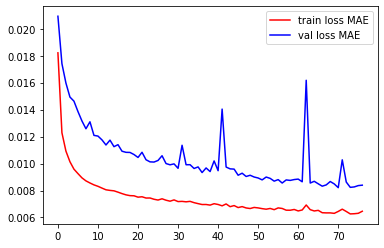

finished training
saved the model


In [32]:
## create data generator, train model and save model.
BG = BatchGenerator()
MT = ModelTrainer()
MT.train_full_model()
print("finished training")
torch.save(MT.strongest_model, model_path + "trained_model")
model = torch.load(model_path + "trained_model")
model.eval()
print("saved the model")

In [59]:
# test model on the full test sample:
criterion1 = nn.L1Loss()
criterion2 = nn.MSELoss()
BG = BatchGenerator()
train_full_loader, valid_full_loader, test_full_loader = BG.load_full_data()

test_lossesMAE_t1 = 0.0
test_lossesMSE_t1 = 0.0
test_lossesMAE_t5 = 0.0
test_lossesMSE_t5 = 0.0
test_lossesMAE_t10 = 0.0
test_lossesMSE_t10 = 0.0
test_lossesMAE_scaled = 0.0

tactile_predictions = []
tactile_groundtruth = []
experiment_time_steps = []
test_lossesMAE = 0.0
test_lossesMSE = 0.0
with torch.no_grad():
    for index__, batch_features in enumerate(test_full_loader):
        # 2. Reshape data and send to device:
        action = batch_features[0].squeeze().permute(1,0,2).to(device)
        tactile = batch_features[1].permute(1,0,2).to(device)
        tactilederiv1 = batch_features[2].permute(1,0,2).to(device)
        tactilederiv2 = batch_features[3].permute(1,0,2).to(device)
        tp = model.forward(tactiles=tactile, actions=action, tac_deriv1=tactilederiv1, tac_deriv2=tactilederiv2) # Step 3. Run our forward pass.
        experiment_time_steps.append([batch_features[-2], batch_features[-1]])
        tp = tp[:,:,:48]
        ############ RESCALE THE DATA HERE ################
        tp_back_scaled = []
        tg_back_scaled = []
        for i in range(len(tp)+1):
            if scale_together == False:
                if i is not 0:
                    # tp:
                    (tpx, tpy, tpz) = np.split(tp[i-1].cpu().detach(), 3, axis=1)
                    xela_x_inverse_minmax = min_max_scalerx_full_data.inverse_transform(tpx)
                    xela_y_inverse_minmax = min_max_scalery_full_data.inverse_transform(tpy)
                    xela_z_inverse_minmax = min_max_scalerz_full_data.inverse_transform(tpz)
                    xela_x_inverse_full = scaler_tx.inverse_transform(xela_x_inverse_minmax)
                    xela_y_inverse_full = scaler_ty.inverse_transform(xela_y_inverse_minmax)
                    xela_z_inverse_full = scaler_tz.inverse_transform(xela_z_inverse_minmax)
                    tp_back_scaled.append(np.concatenate((xela_x_inverse_full,
                                                         xela_y_inverse_full,
                                                         xela_z_inverse_full), axis=1))
                # tg:
                (tpx, tpy, tpz) = np.split(tactile[context_frames-1:][i].cpu().detach(), 3, axis=1)
                xela_x_inverse_minmax = min_max_scalerx_full_data.inverse_transform(tpx)
                xela_y_inverse_minmax = min_max_scalery_full_data.inverse_transform(tpy)
                xela_z_inverse_minmax = min_max_scalerz_full_data.inverse_transform(tpz)
                xela_x_inverse_full = scaler_tx.inverse_transform(xela_x_inverse_minmax)
                xela_y_inverse_full = scaler_ty.inverse_transform(xela_y_inverse_minmax)
                xela_z_inverse_full = scaler_tz.inverse_transform(xela_z_inverse_minmax)
                tg_back_scaled.append(np.concatenate((xela_x_inverse_full,
                                                     xela_y_inverse_full,
                                                     xela_z_inverse_full), axis=1))
            else:            
                tactile_prediction_decoded = min_max_scaler_xela_sensor1_principle_components.inverse_transform(tp[i].cpu().detach())
                tp_back_scaled.append(scaler_full.inverse_transform(tactile_prediction_decoded))
                tactile_gt_decoded = min_max_scaler_xela_sensor1_principle_components.inverse_transform(tactile[context_frames:][i].cpu().detach())
                tg_back_scaled.append(scaler_full.inverse_transform(tactile_gt_decoded))

        tp_back_scaled = torch.from_numpy(np.asarray(tp_back_scaled))
        tg_back_scaled = torch.from_numpy(np.asarray(tg_back_scaled))
        tactile_predictions.append(tp_back_scaled)
        tactile_groundtruth.append(tg_back_scaled)

        # calculate losses for specific timesteps
        test_lossesMAE_scaled += criterion1(tp, tactile[context_frames:]).item()
        test_lossesMAE += criterion1(tp_back_scaled, tg_back_scaled[1:]).item()
        test_lossesMSE += criterion2(tp_back_scaled, tg_back_scaled[1:]).item()
        test_lossMAE_t1 = criterion1(tp_back_scaled[0,:,:], tg_back_scaled[1,:,:])
        test_lossesMAE_t1 += test_lossMAE_t1.item()
        test_lossMSE_t1 = criterion2(tp_back_scaled[0,:,:], tg_back_scaled[1,:,:])
        test_lossesMSE_t1 += test_lossMSE_t1.item()
        test_lossMAE_t5 = criterion1(tp_back_scaled[4,:,:], tg_back_scaled[5,:,:])
        test_lossesMAE_t5 += test_lossMAE_t5.item()
        test_lossMSE_t5 = criterion2(tp_back_scaled[4,:,:], tg_back_scaled[5,:,:])
        test_lossesMSE_t5 += test_lossMSE_t5.item()
        test_lossMAE_t10 = criterion1(tp_back_scaled[9,:,:], tg_back_scaled[10,:,:])
        test_lossesMAE_t10 += test_lossMAE_t10.item()
        test_lossMSE_t10 = criterion2(tp_back_scaled[9,:,:], tg_back_scaled[10,:,:])
        test_lossesMSE_t10 += test_lossMSE_t10.item()

performance_data = []
performance_data.append(["unscaled test loss MAE(L1): ", (test_lossesMAE_scaled / index__)])
performance_data.append(["test loss MAE(L1): ", (test_lossesMAE / index__)])
performance_data.append(["test loss MSE: ", (test_lossesMSE / index__)])
performance_data.append(["test loss MAE(L1) timestep 1: ", (test_lossesMAE_t1 / index__)])
performance_data.append(["test loss MSE timestep 1: ", (test_lossesMSE_t1 / index__)])
performance_data.append(["test loss MAE(L1) timestep 5: ", (test_lossesMAE_t5 / index__)])
performance_data.append(["test loss MSE timestep 5: ", (test_lossesMSE_t5 / index__)])
performance_data.append(["test loss MAE(L1) timestep 9: ", (test_lossesMAE_t10 / index__)])
performance_data.append(["test loss MSE timestep 9: ", (test_lossesMSE_t10 / index__)])
[print(i) for i in performance_data]

np.save(model_path + 'performance_data', np.asarray(performance_data))

/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/

torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])


/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/

torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])


/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/

torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])


/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/

torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])


/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/

torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])


/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/

torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])


/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/

torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])


/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/

torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])


/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/

torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])


/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/

torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])


/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/

torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])


/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/

torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])


/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/

torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])


/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/

torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])


/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/

torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])


/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/

torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])


/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/

torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])


/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/

torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])


/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/

torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])


/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/

torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])


/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/

torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])


/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/

torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])


/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/

torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])


/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/

torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])


/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/

torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])


/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/

torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])


/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/

torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])


/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/

torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])


/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/

torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])


/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/

torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])


/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/

torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])


/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/

torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])


/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/

torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 32, 48])
torch.Size([11, 19, 48])
['unscaled test loss MAE(L1): ', 0.015847513465790674]
['test loss MAE(L1): ', 84.35844688269202]
['test loss MSE: ', 68214.78782505749]
['test loss MAE(L1) timestep 1: ', 53.81618072269283]
['test loss MSE timestep 1: ', 20981.49813636189]
['test loss MAE(L1) timestep 5: ', 82.09966992982805]
['test loss MSE timestep 5: ', 56659.395773803626]
['test loss MAE(L1) timestep 9: ', 104.15253464992753]
['test loss MSE timestep 9: ', 119538.48611897217]
done


/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/home/user/Robotics/slip_detection_model/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

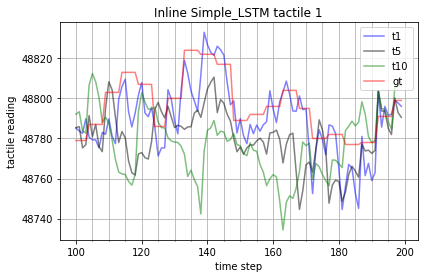

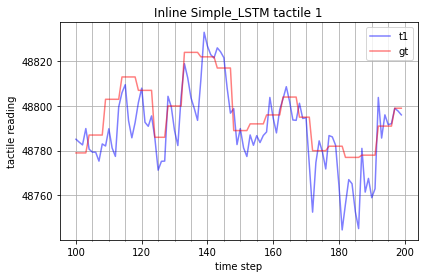

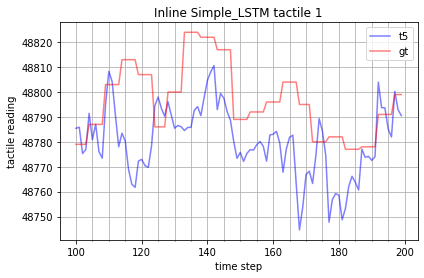

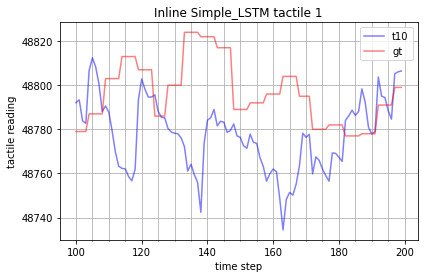

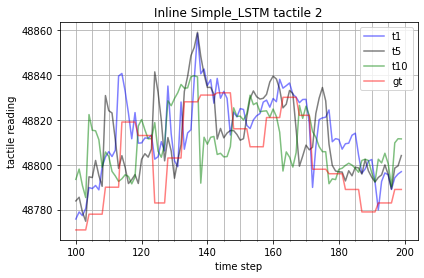

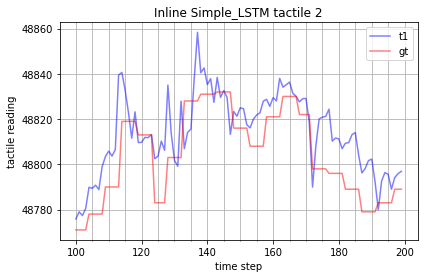

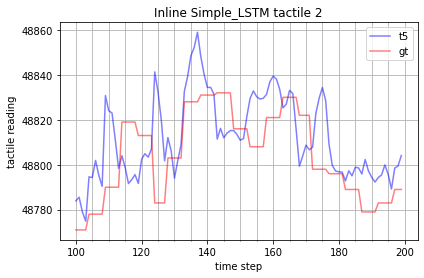

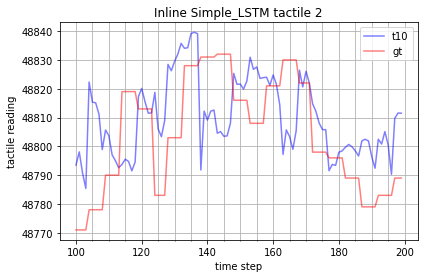

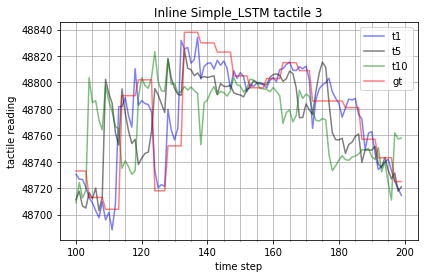

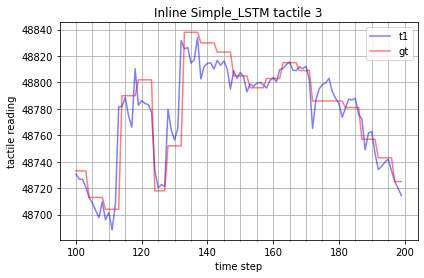

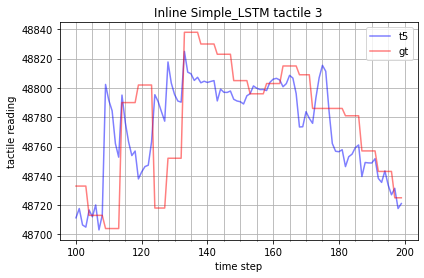

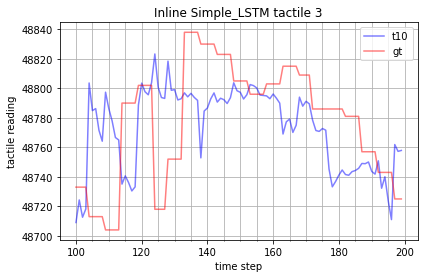

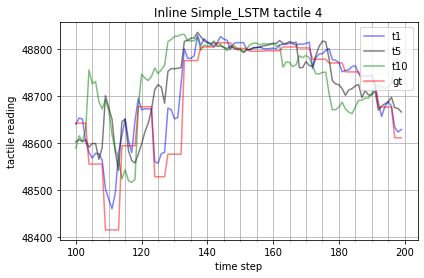

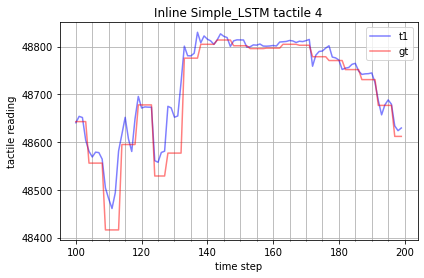

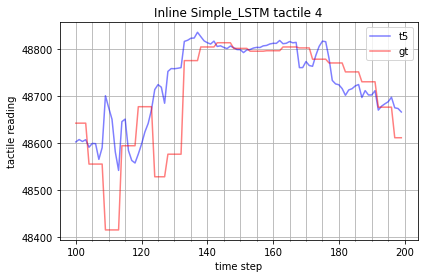

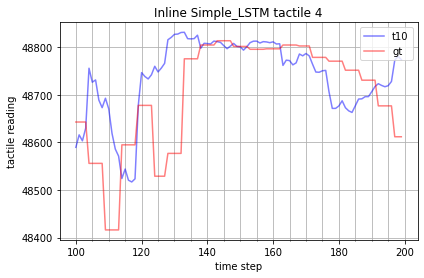

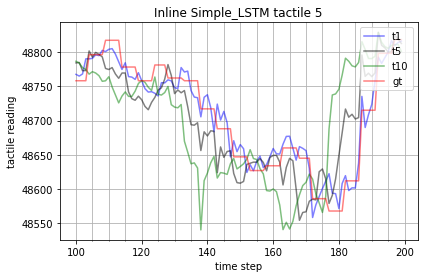

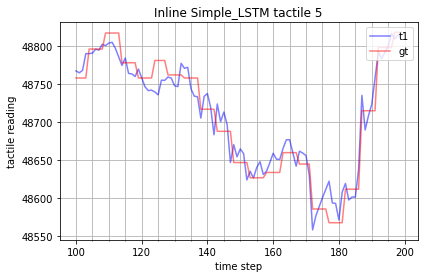

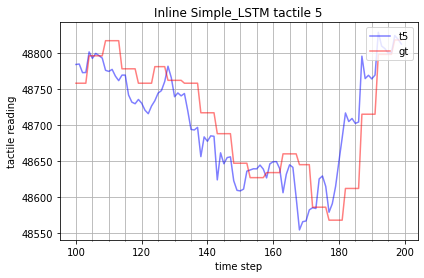

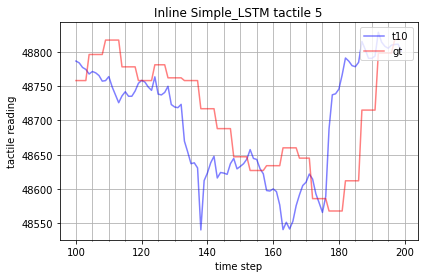

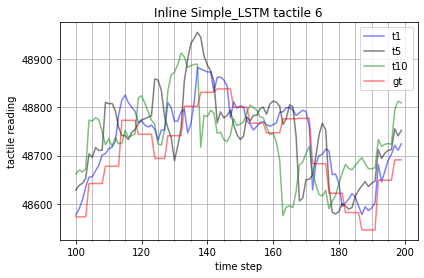

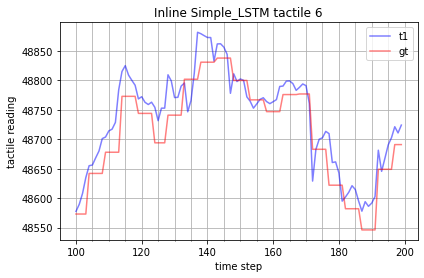

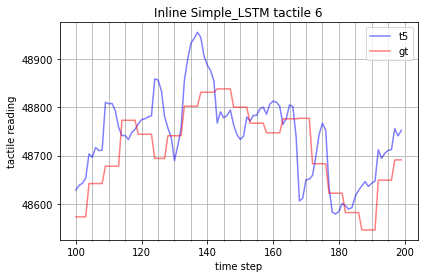

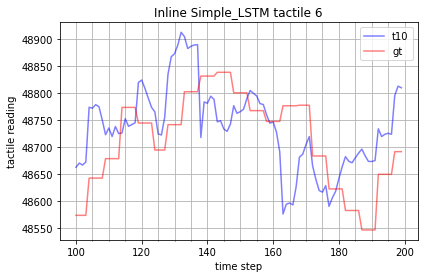

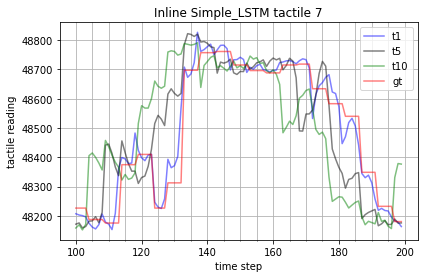

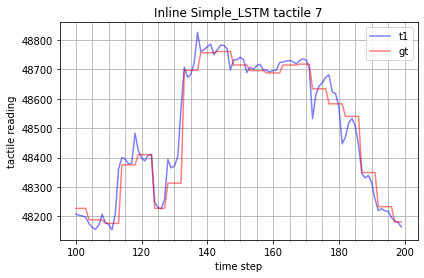

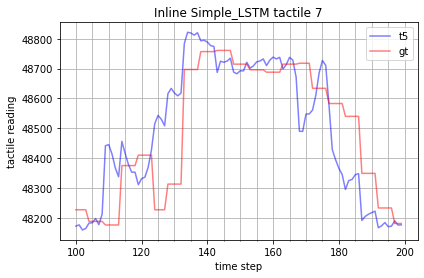

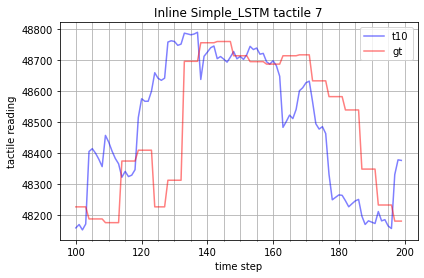

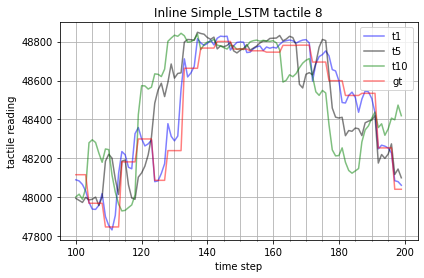

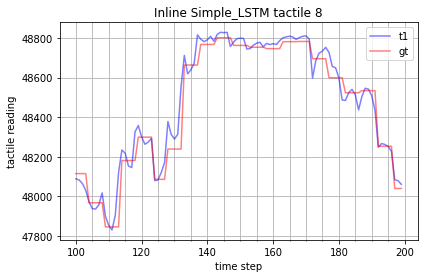

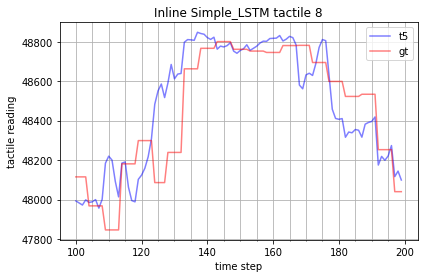

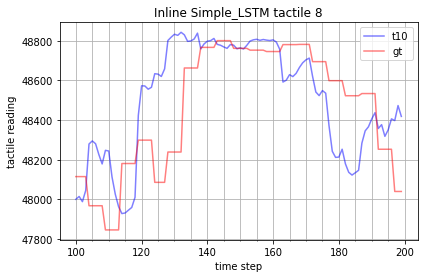

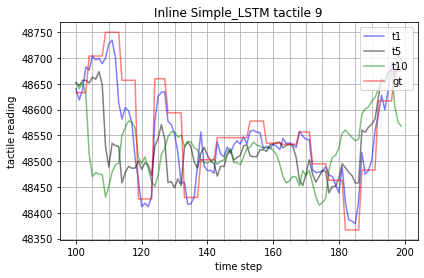

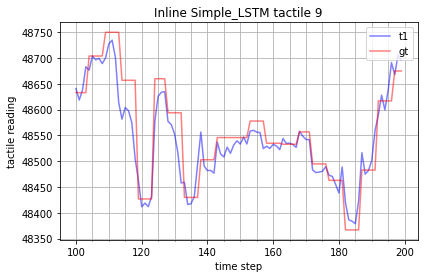

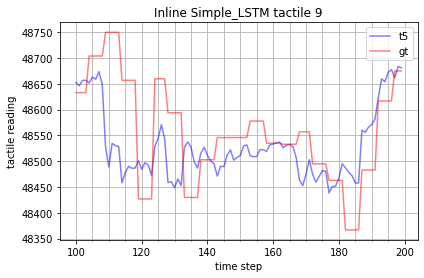

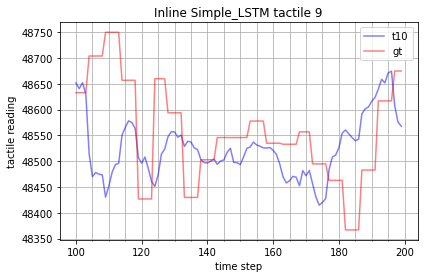

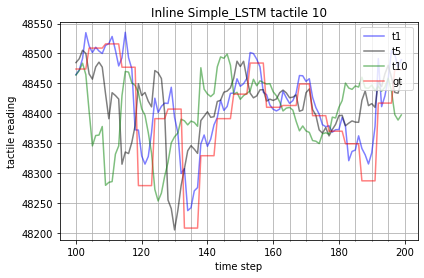

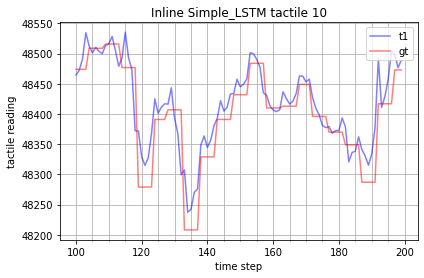

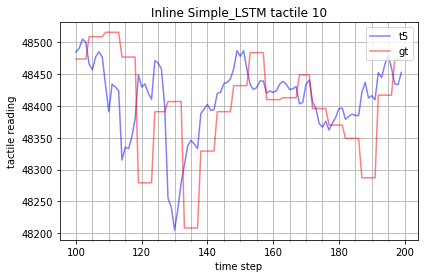

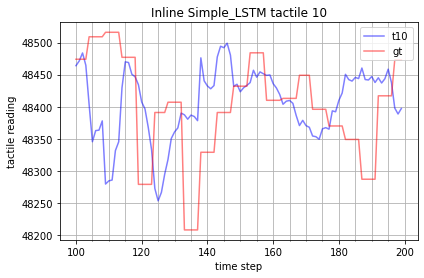

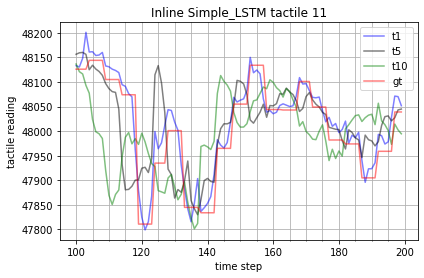

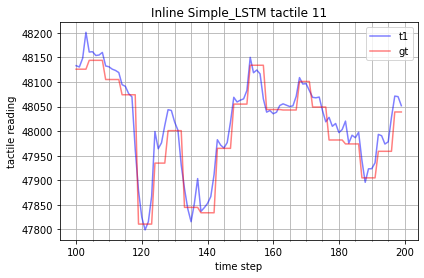

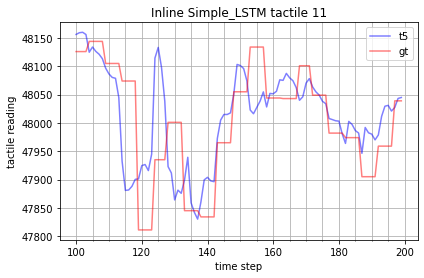

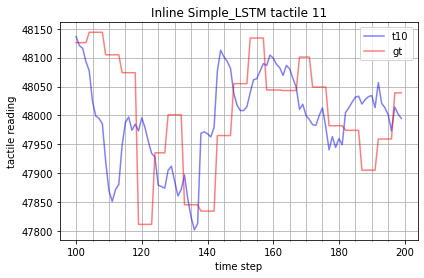

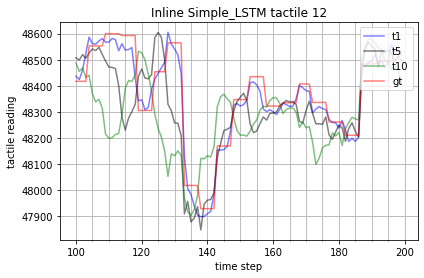

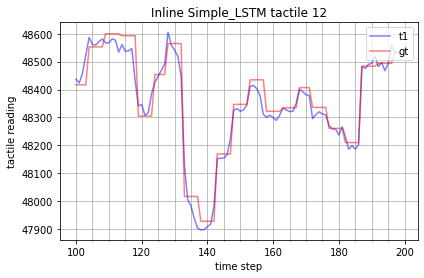

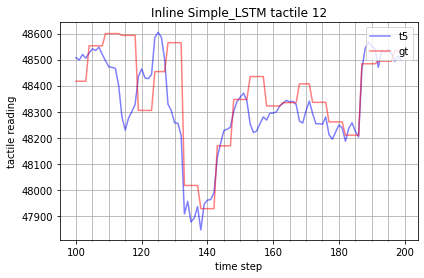

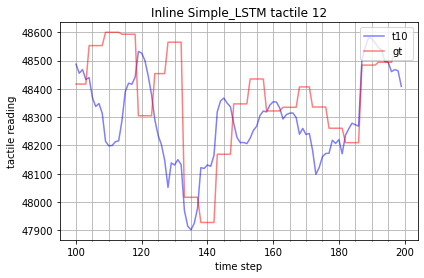

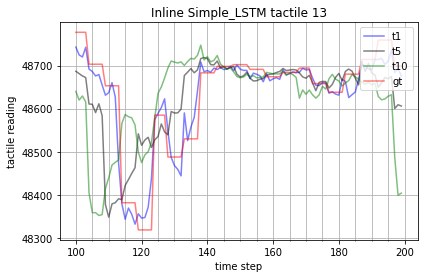

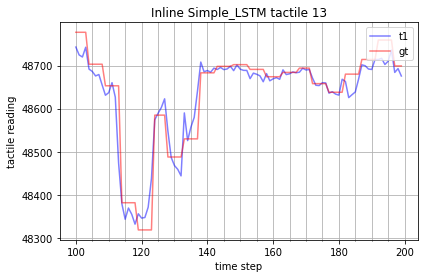

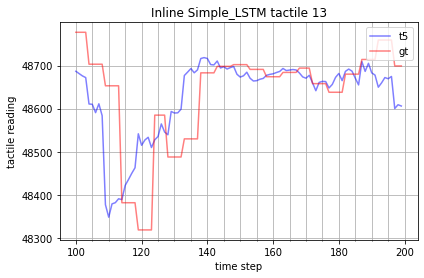

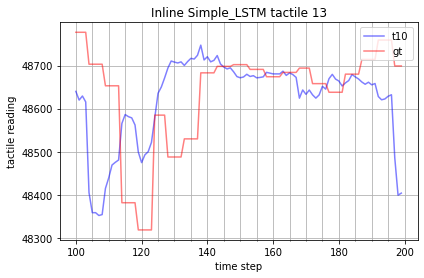

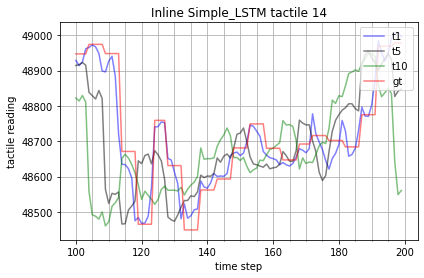

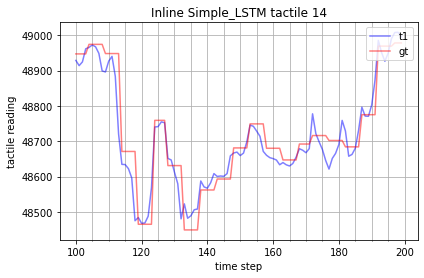

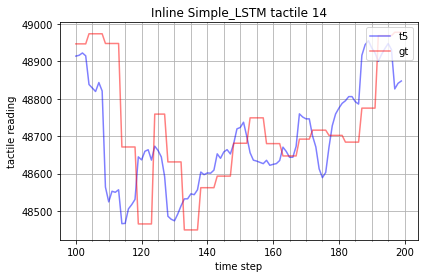

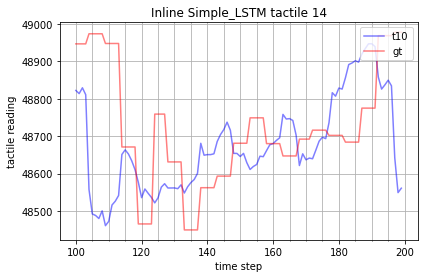

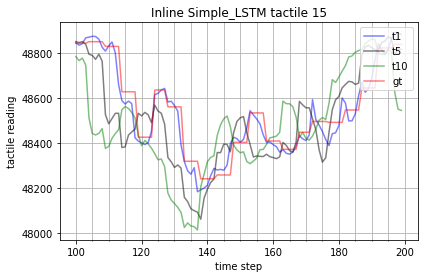

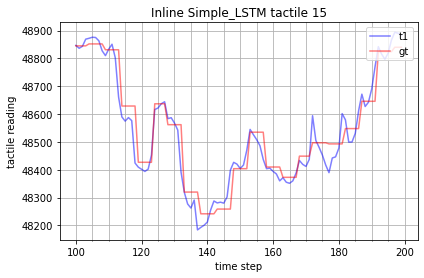

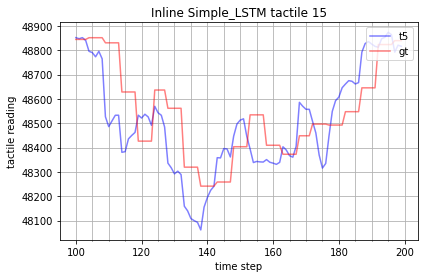

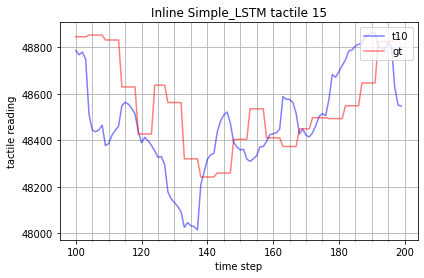

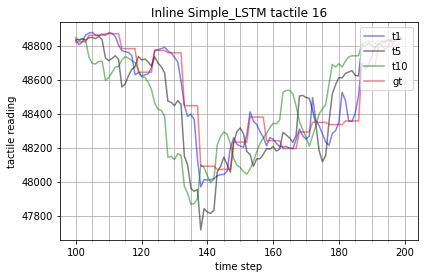

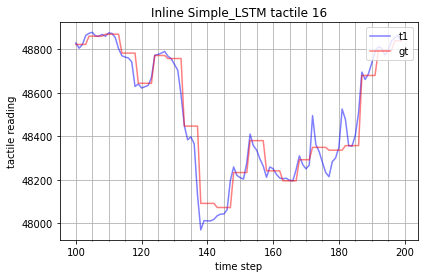

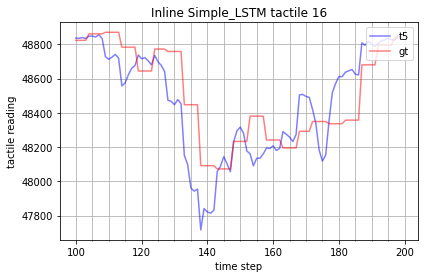

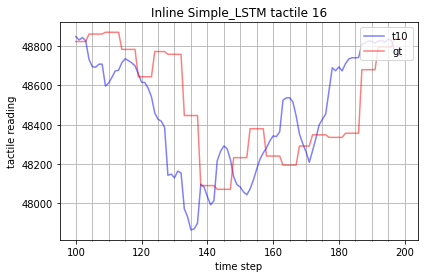

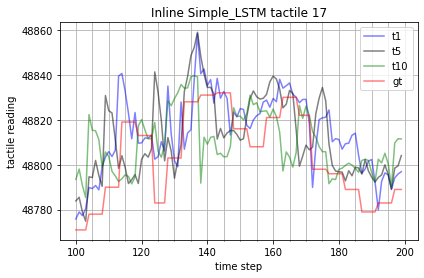

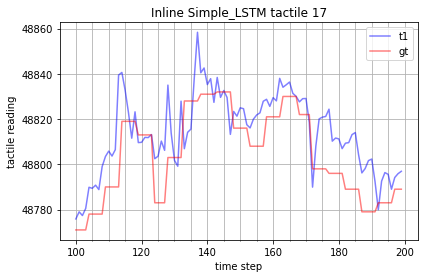

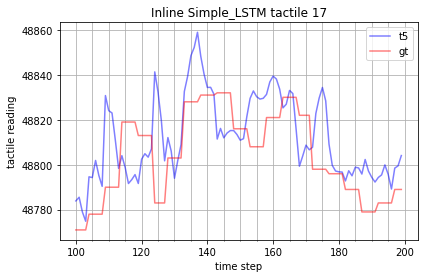

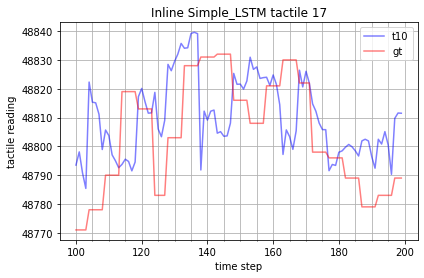

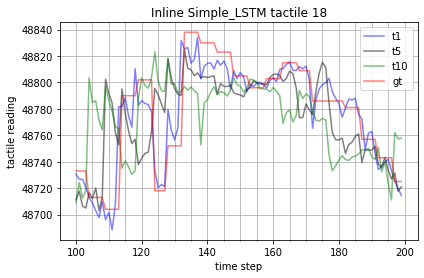

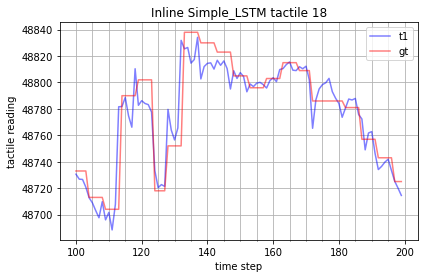

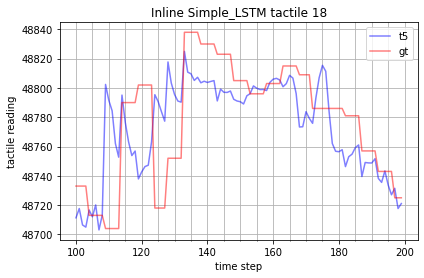

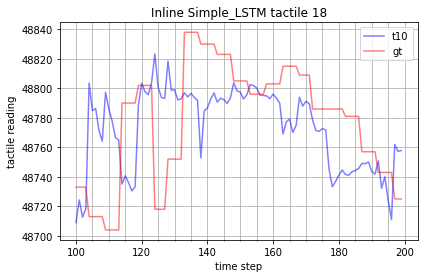

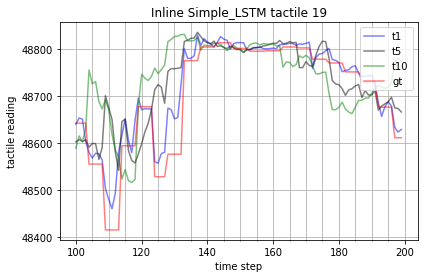

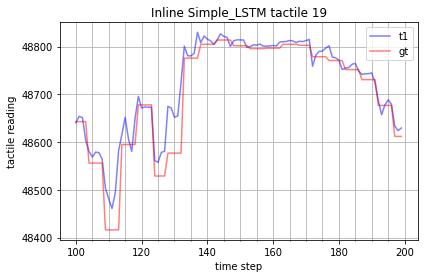

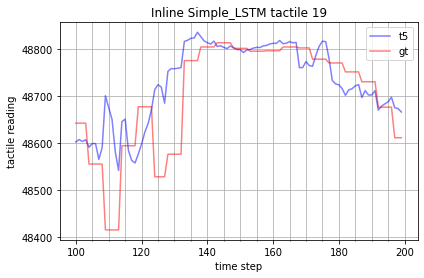

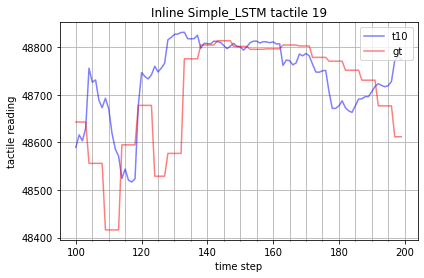

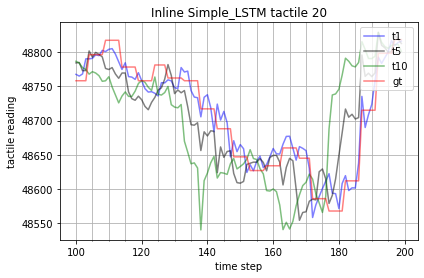

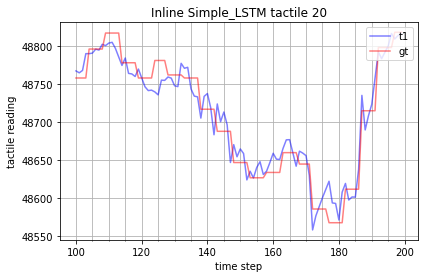

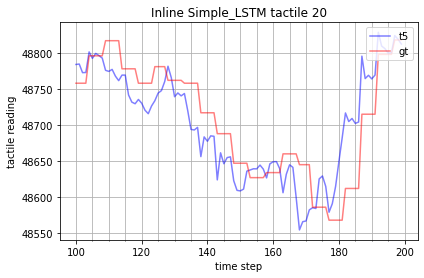

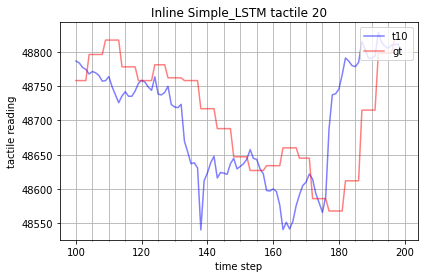

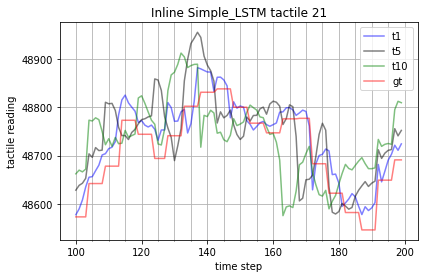

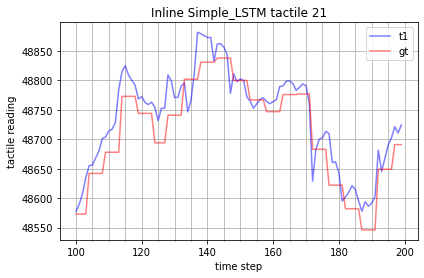

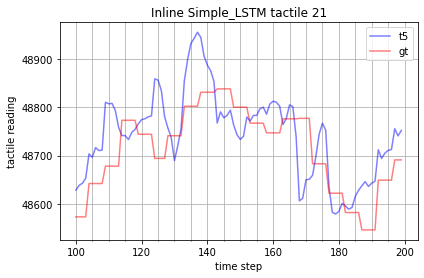

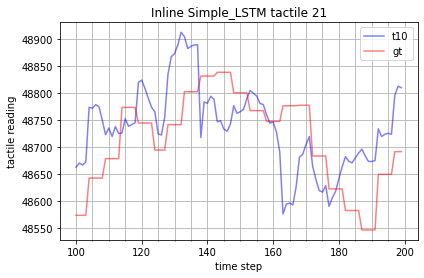

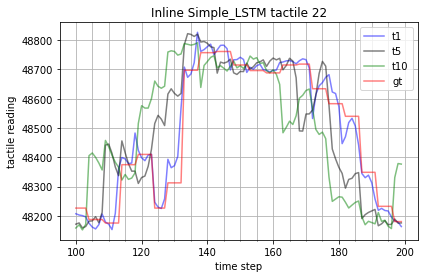

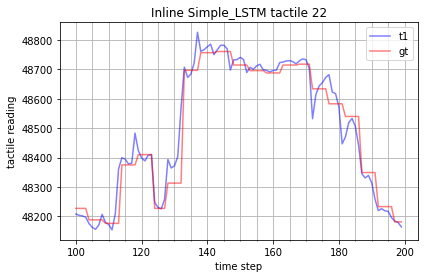

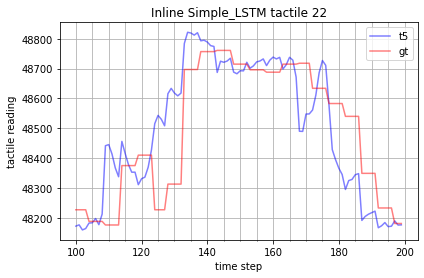

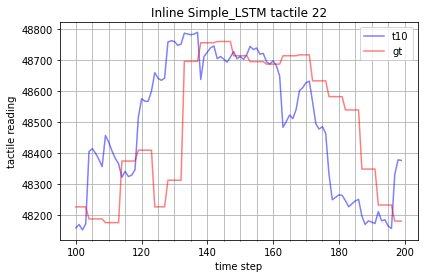

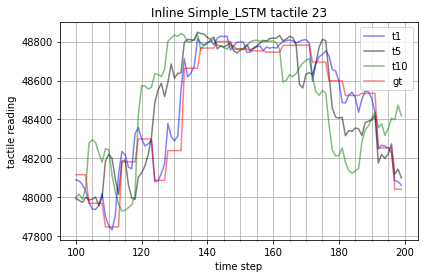

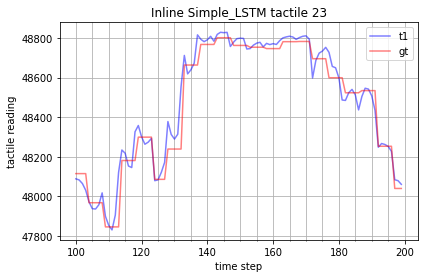

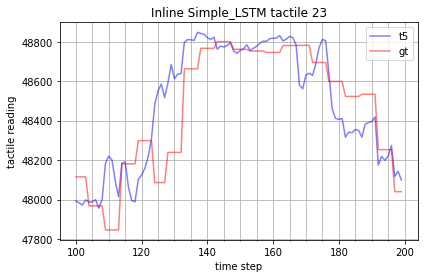

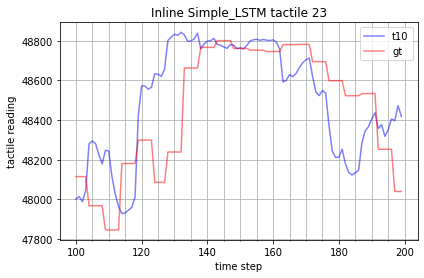

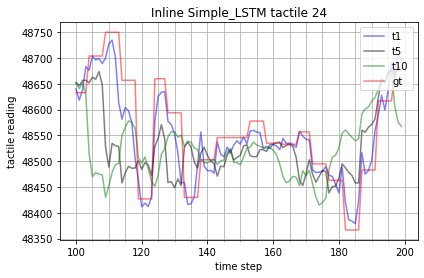

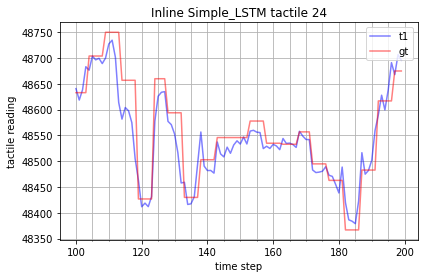

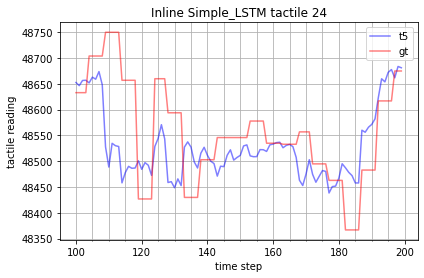

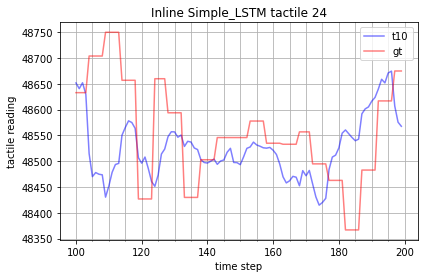

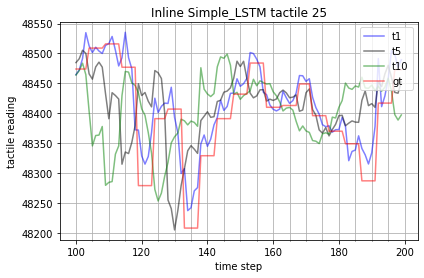

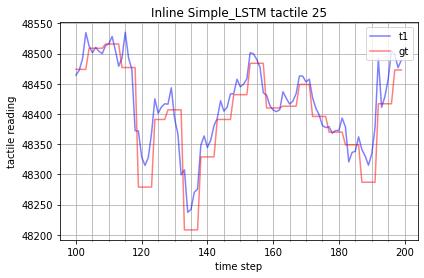

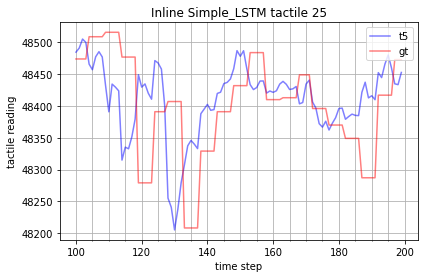

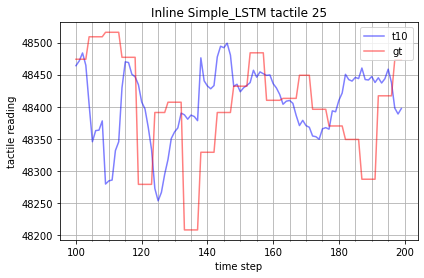

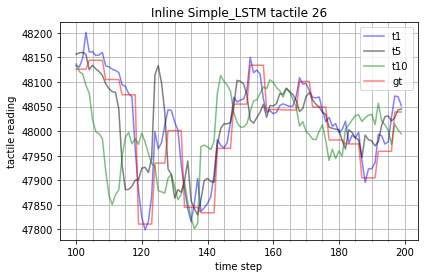

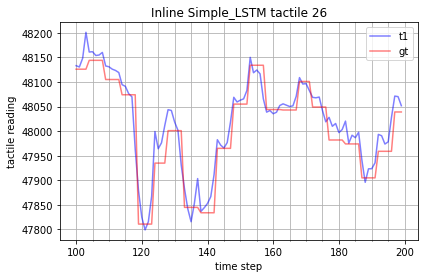

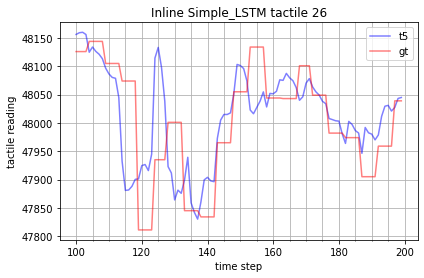

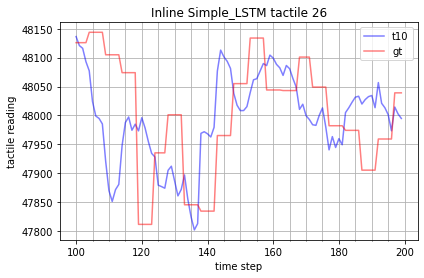

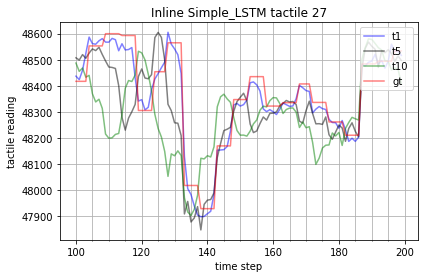

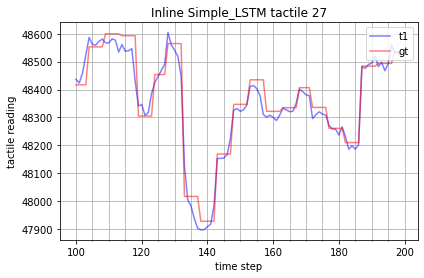

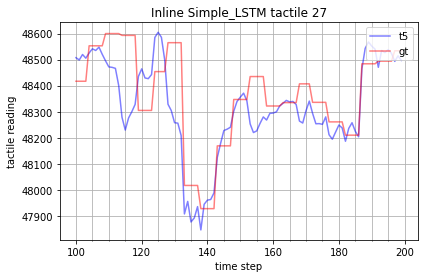

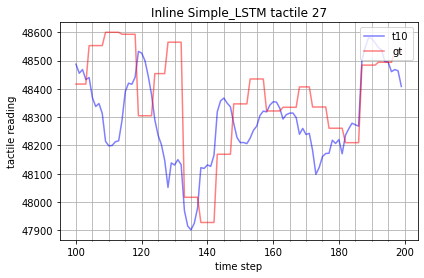

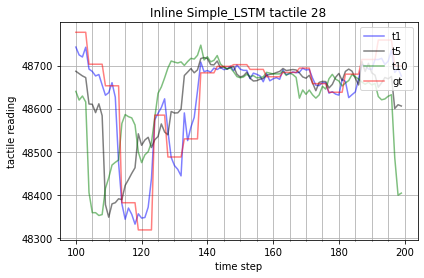

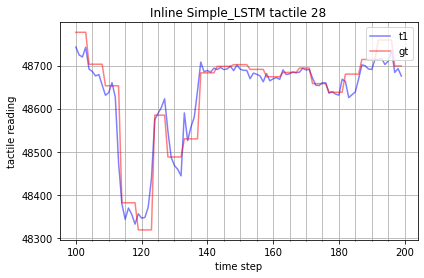

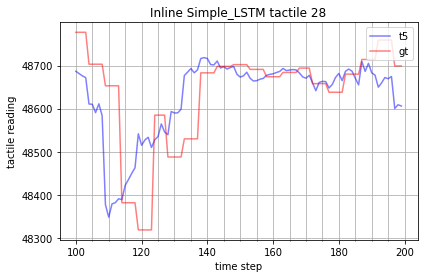

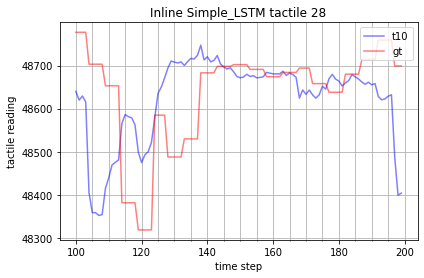

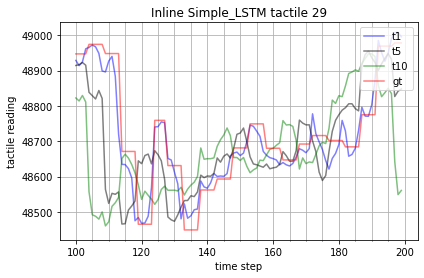

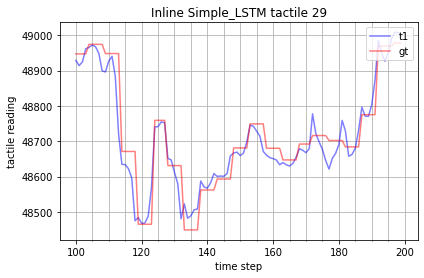

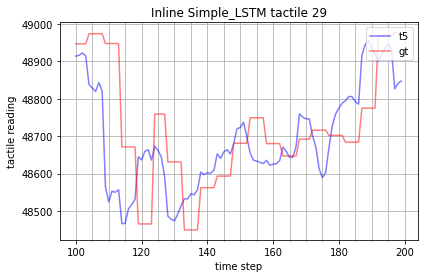

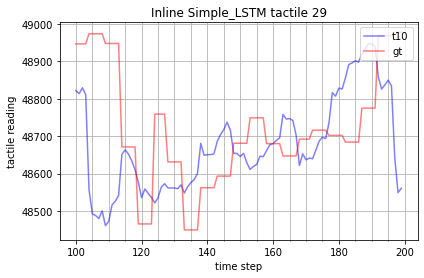

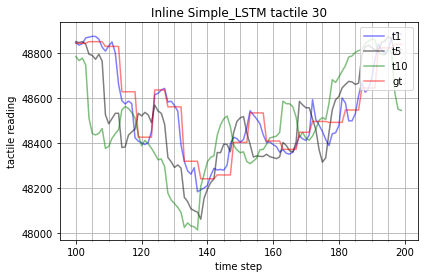

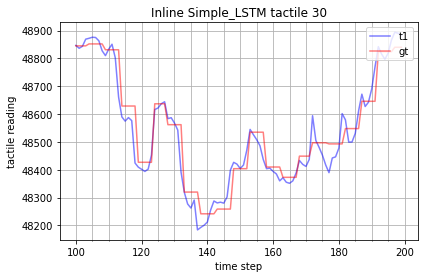

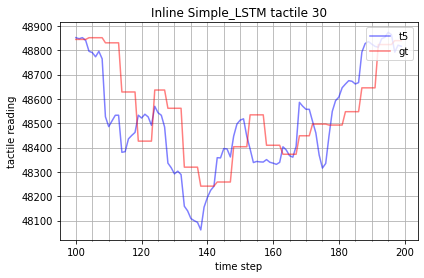

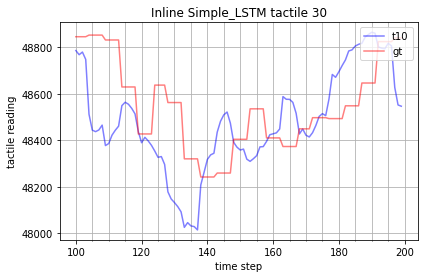

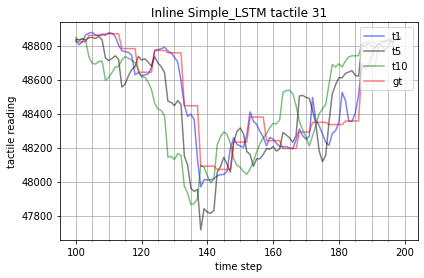

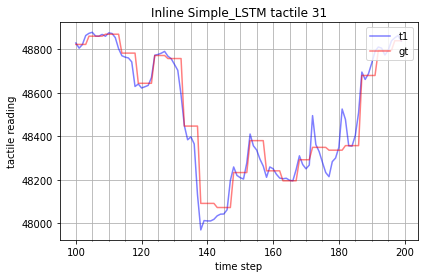

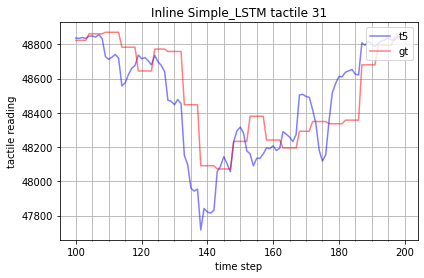

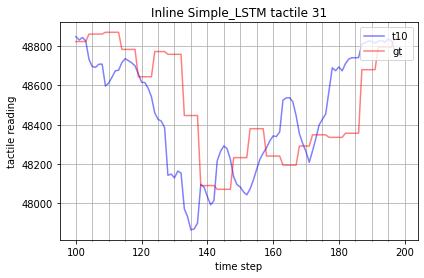

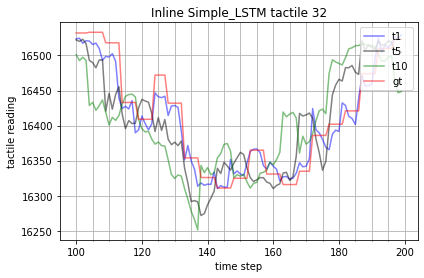

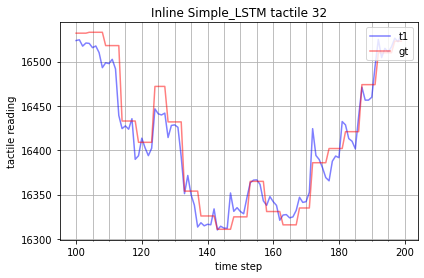

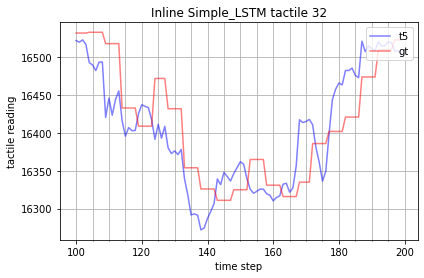

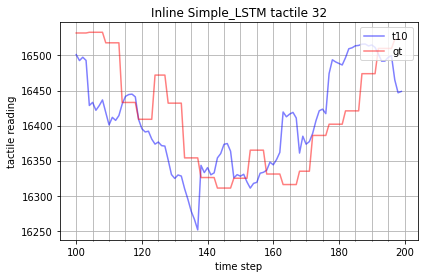

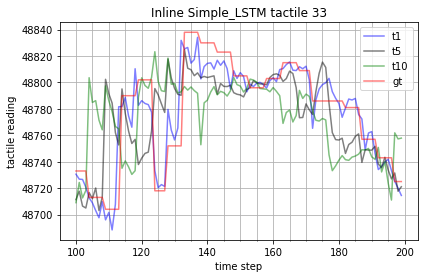

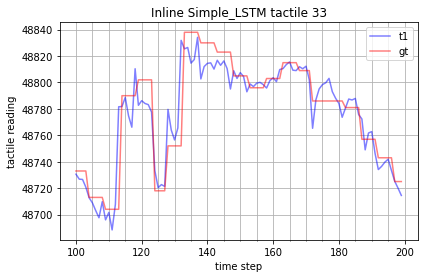

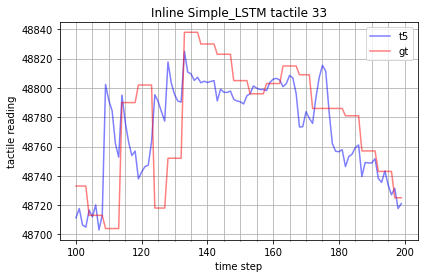

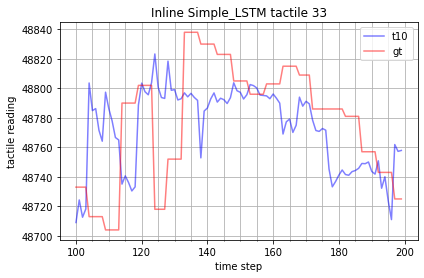

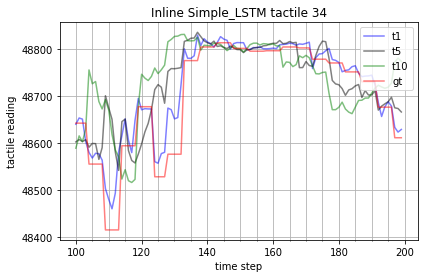

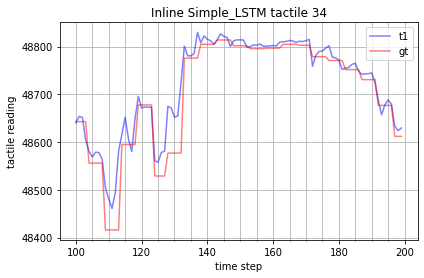

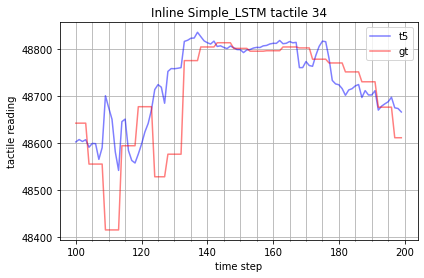

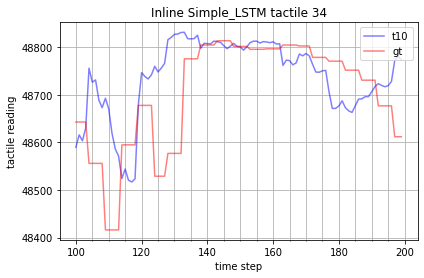

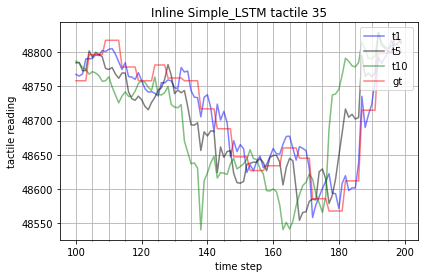

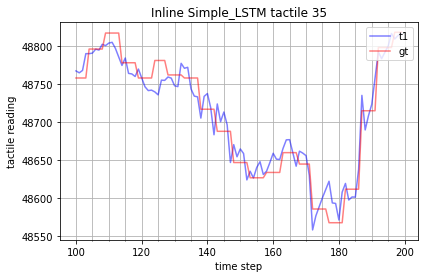

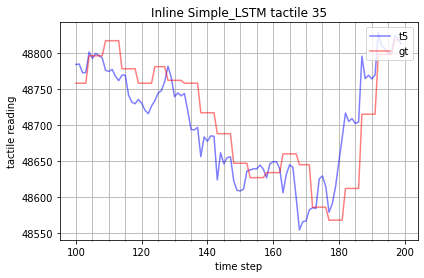

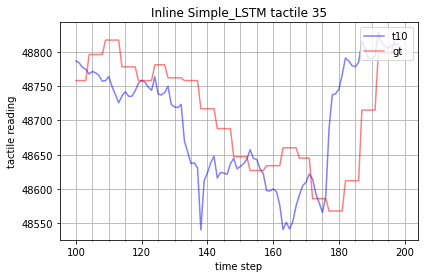

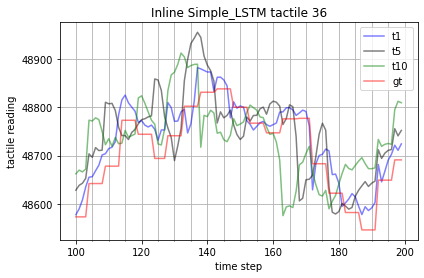

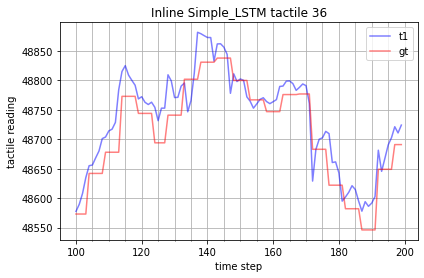

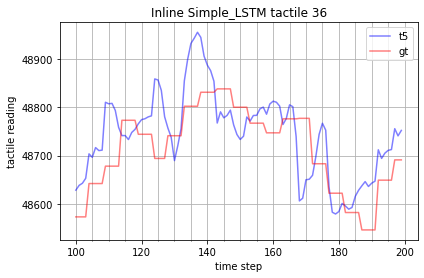

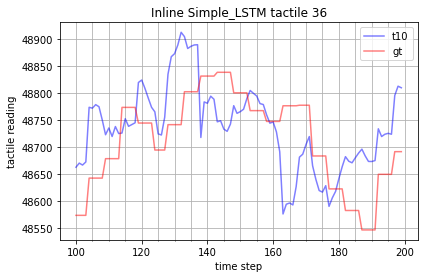

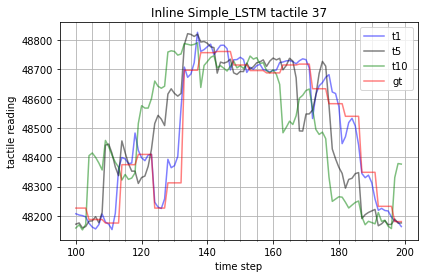

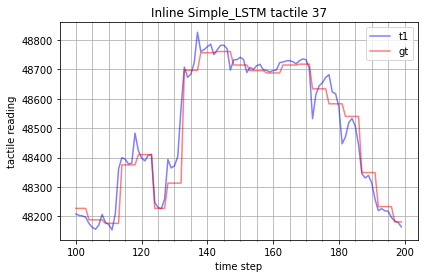

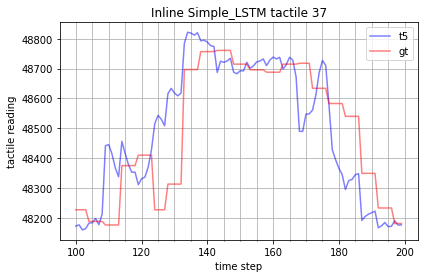

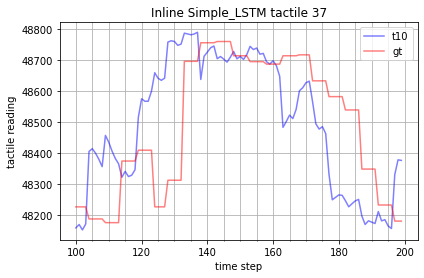

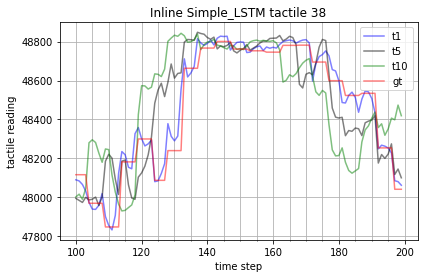

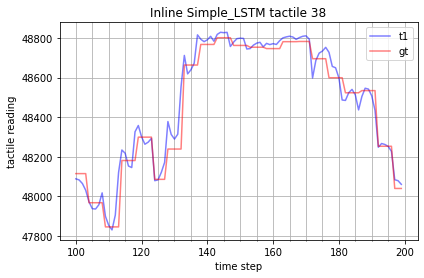

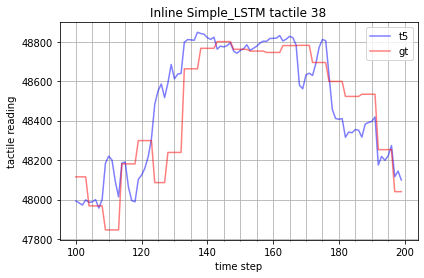

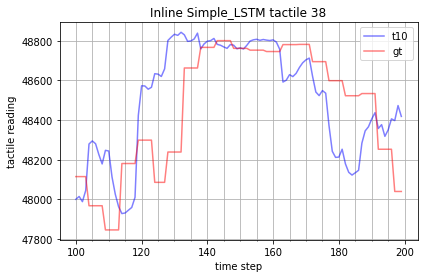

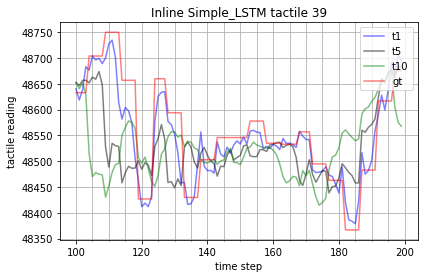

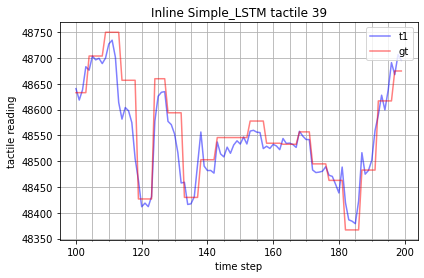

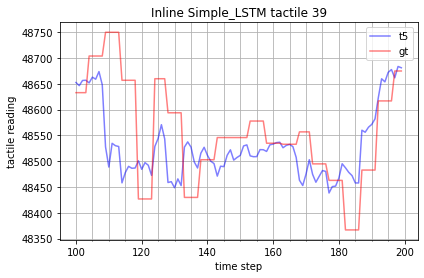

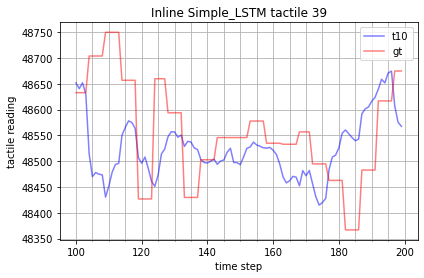

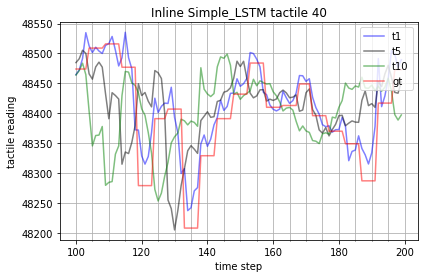

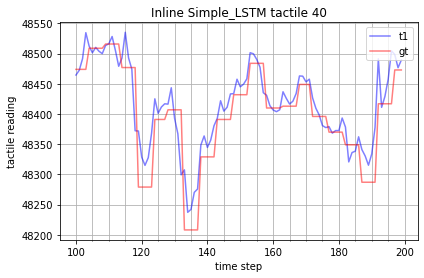

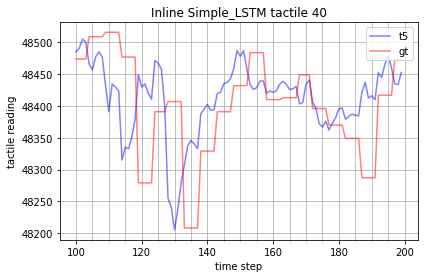

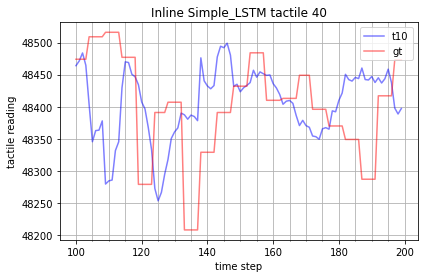

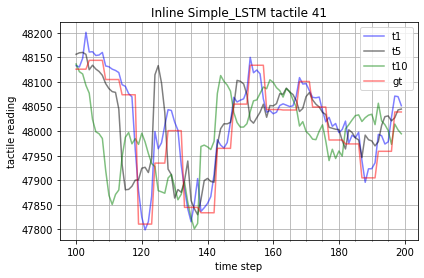

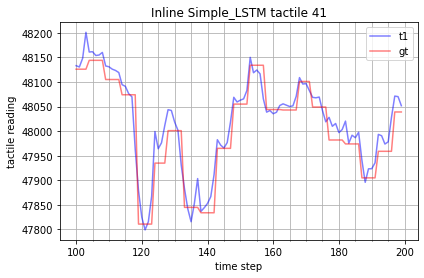

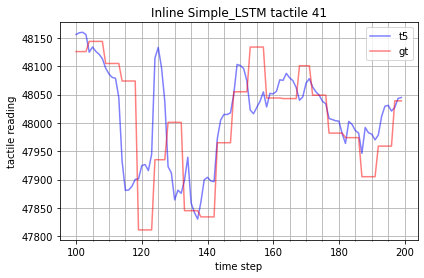

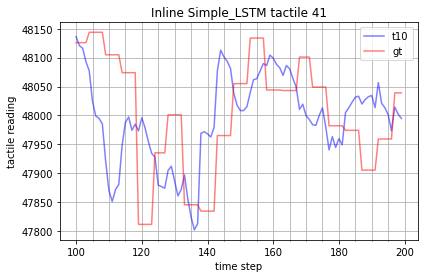

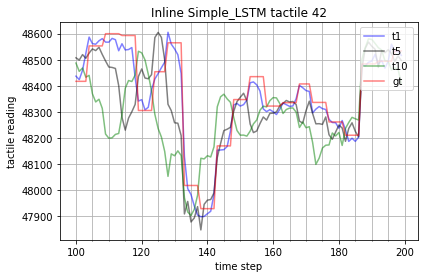

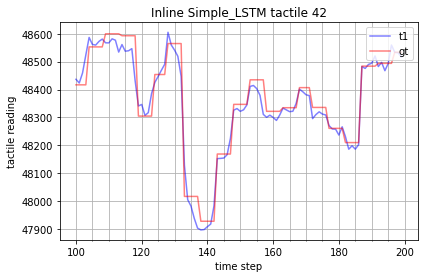

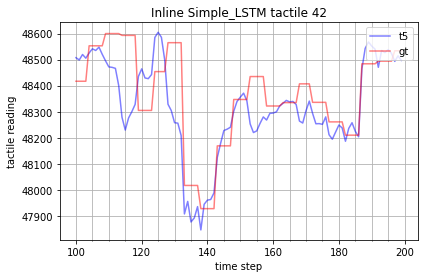

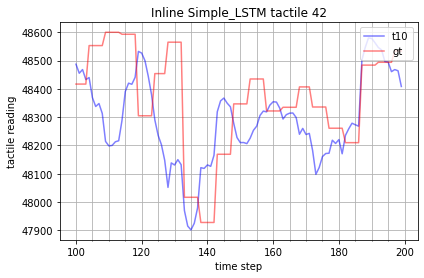

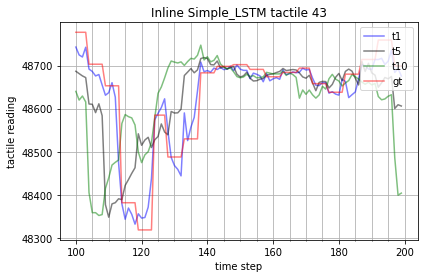

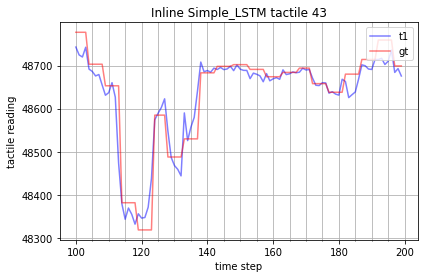

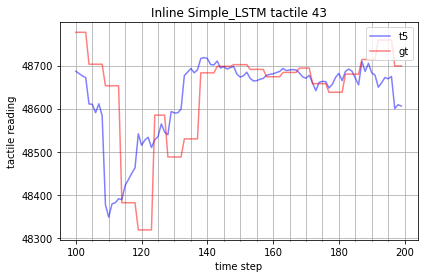

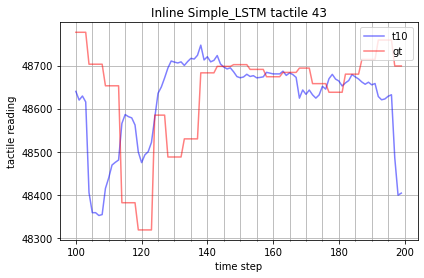

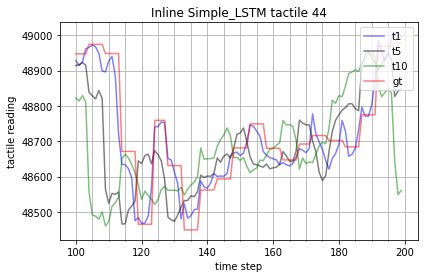

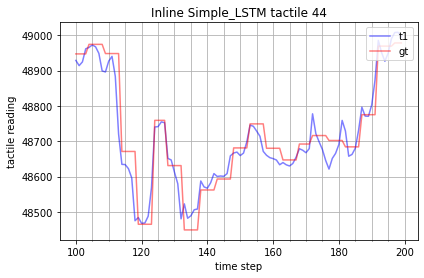

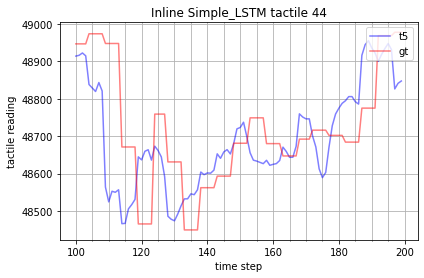

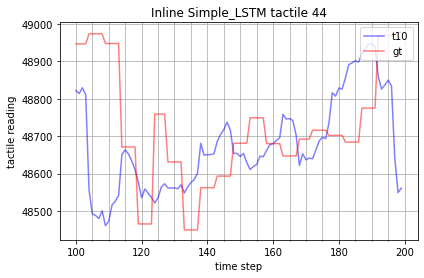

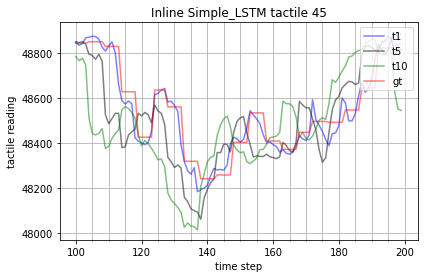

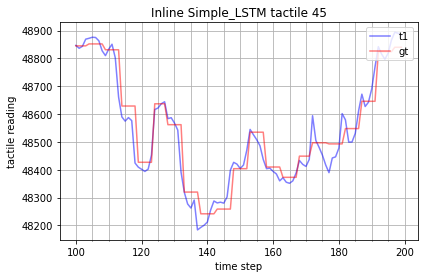

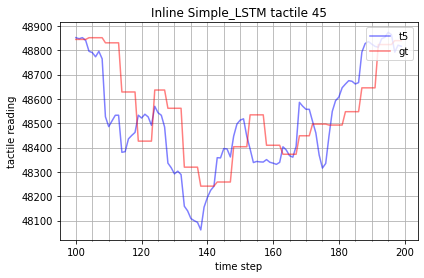

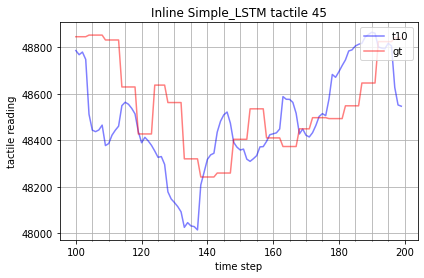

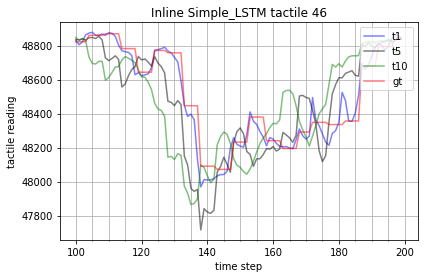

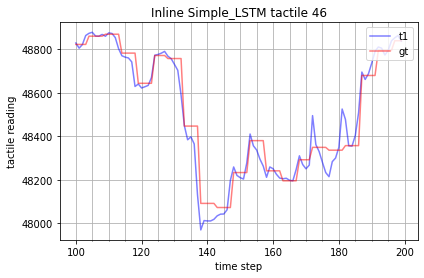

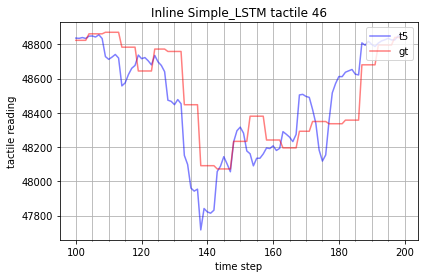

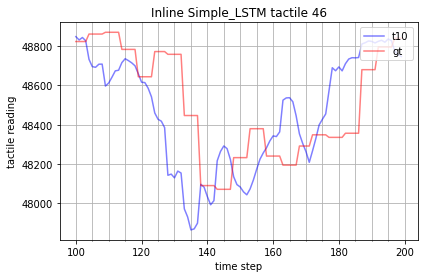

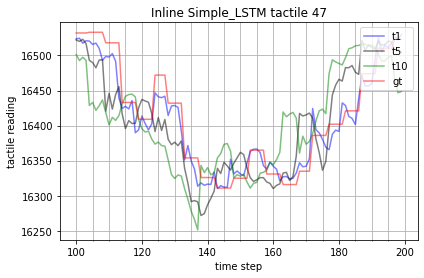

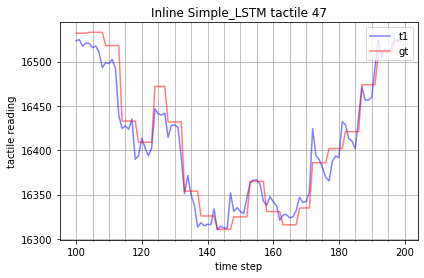

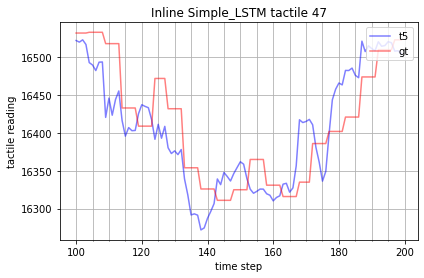

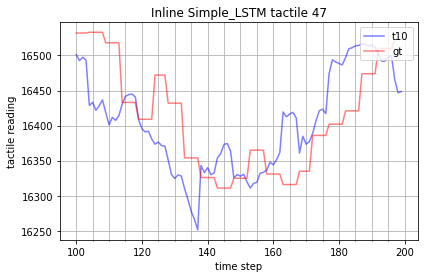

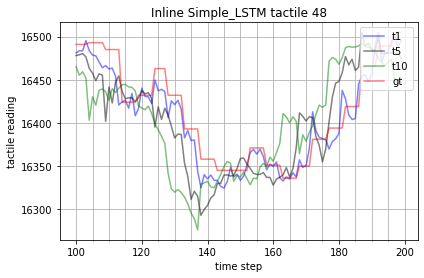

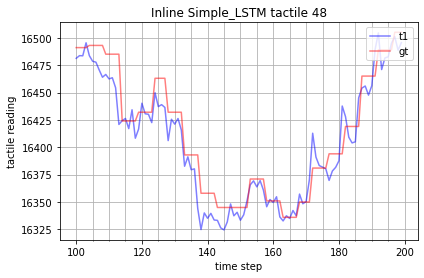

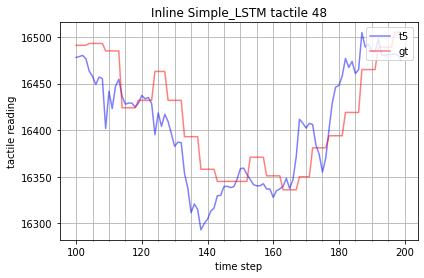

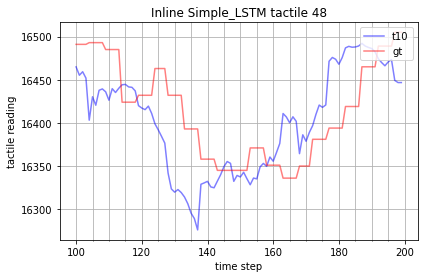

In [61]:
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
# calculate tactile values for full sample:
time_step_to_test_t1 = 0    # [batch_set, prediction frames(t1->tx)(6), batch_size, features(48)]
time_step_to_test_t5 = 4
time_step_to_test_t9 = 9
predicted_data_t1 = []
predicted_data_t5 = []
predicted_data_t9 = []
groundtruth_data = []
time_stepsto_plot = []
experiment_to_test = 211 # len(p) - 1  # experiment 106 as its the last one
for index, batch_set in enumerate(tactile_predictions):
    for batch in range(0, len(batch_set[0])):
        experiment = experiment_time_steps[index][0][batch][0].numpy()
        time_step = experiment_time_steps[index][1][batch][0].numpy()
        if experiment == experiment_to_test:
            prediction_values = batch_set[time_step_to_test_t1][batch]
            predicted_data_t1.append(prediction_values)
            prediction_values = batch_set[time_step_to_test_t5][batch]
            predicted_data_t5.append(prediction_values)
            prediction_values = batch_set[time_step_to_test_t9][batch]
            predicted_data_t9.append(prediction_values)
            gt_values = tactile_groundtruth[index][time_step_to_test_t1][batch]
            groundtruth_data.append(gt_values)
            time_stepsto_plot.append(time_step.item())
print(time_stepsto_plot)

# test data
index = 0
plot_range_start = 100 # 0
plot_range_stop  = 200 # len(time_stepsto_plot)
titles = ["sheerx", "sheery", "normal"]
for j in range(3):
    for i in range(16):
        groundtruth_taxle = []
        predicted_taxel = []
        predicted_taxel_t1 = []
        predicted_taxel_t5 = []
        predicted_taxel_t9 = []
        # good = 140, 145 (lifting up the )
        for k in range(plot_range_start, plot_range_stop):# len(predicted_data_t1)):#310, 325):#len(predicted_data_t1)):  # add in length of context data
            predicted_taxel_t1.append(predicted_data_t1[k][j+i].cpu().detach().numpy())
            predicted_taxel_t5.append(predicted_data_t5[k][j+i].cpu().detach().numpy())
            predicted_taxel_t9.append(predicted_data_t9[k][j+i].cpu().detach().numpy())
            groundtruth_taxle.append(groundtruth_data[k][j+i].cpu().detach().numpy())

        index += 1
        fig, ax1 = plt.subplots()
        ax1.set_xlabel('time step')
        ax1.set_ylabel('tactile reading')
        ax1.plot([value for value in time_stepsto_plot[plot_range_start:plot_range_stop]], [i for i in predicted_taxel_t1], alpha=0.5, c="b", label="t1")
        ax1.plot([value for value in time_stepsto_plot[plot_range_start:plot_range_stop]], [i for i in predicted_taxel_t5], alpha=0.5, c="k", label="t5")
        ax1.plot([value for value in time_stepsto_plot[plot_range_start:plot_range_stop]], [i for i in predicted_taxel_t9], alpha=0.5, c="g", label="t10")
        ax1.plot([value for value in time_stepsto_plot[plot_range_start:plot_range_stop]], groundtruth_taxle, alpha=0.5, c="r", label="gt")
        ax1.tick_params(axis='y')
        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        fig.subplots_adjust(top=0.90)
        ax1.legend(loc="upper right")
        
        ax1.xaxis.set_minor_locator(AutoMinorLocator())
        ax1.tick_params(which='minor', length=1, color='k')
        ax1.grid(which='minor')
        ax1.grid(which='major')
        
        plt.title("Inline Simple_LSTM tactile " + str(index))
#         plt.savefig(model_path + '/' + str(experiment_to_test) + '/zeros_bigger_pconcat_double_data_model_sample_test_with_loss_' + str(index) + '.png', dpi=300)
        plt.show()

        fig, ax1 = plt.subplots()
        ax1.set_xlabel('time step')
        ax1.set_ylabel('tactile reading')
        ax1.plot([value for value in time_stepsto_plot[plot_range_start:plot_range_stop]], [i for i in predicted_taxel_t1], alpha=0.5, c="b", label="t1")
        ax1.plot([value for value in time_stepsto_plot[plot_range_start:plot_range_stop]], groundtruth_taxle, alpha=0.5, c="r", label="gt")
        ax1.tick_params(axis='y')
        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        fig.subplots_adjust(top=0.90)
        ax1.legend(loc="upper right")
        plt.title("Inline Simple_LSTM tactile " + str(index))
        ax1.xaxis.set_minor_locator(AutoMinorLocator())
        ax1.tick_params(which='minor', length=1, color='k')
        ax1.grid(which='minor')
        ax1.grid(which='major')
#         plt.savefig(model_path + '/' + str(experiment_to_test) + '/zeros_bigger_pconcat_double_data_model_T0sample_test_with_loss_' + str(index) + '.png', dpi=300)
        plt.show()
        
        fig, ax1 = plt.subplots()
        ax1.set_xlabel('time step')
        ax1.set_ylabel('tactile reading')
        ax1.plot([value for value in time_stepsto_plot[plot_range_start:plot_range_stop]], [i for i in predicted_taxel_t5], alpha=0.5, c="b", label="t5")
        ax1.plot([value for value in time_stepsto_plot[plot_range_start:plot_range_stop]], groundtruth_taxle, alpha=0.5, c="r", label="gt")
        ax1.tick_params(axis='y')
        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        fig.subplots_adjust(top=0.90)
        ax1.legend(loc="upper right")
        ax1.xaxis.set_minor_locator(AutoMinorLocator())
        ax1.tick_params(which='minor', length=1, color='k')
        ax1.grid(which='minor')
        ax1.grid(which='major')
        plt.title("Inline Simple_LSTM tactile " + str(index))
#         plt.savefig(model_path + '/' + str(experiment_to_test) + '/zeros_bigger_pconcat_double_data_model_T5sample_test_with_loss_' + str(index) + '.png', dpi=300)
        plt.show()
            
        fig, ax1 = plt.subplots()
        ax1.set_xlabel('time step')
        ax1.set_ylabel('tactile reading')
        ax1.plot([value for value in time_stepsto_plot[plot_range_start:plot_range_stop]], [i for i in predicted_taxel_t9], alpha=0.5, c="b", label="t10")
        ax1.plot([value for value in time_stepsto_plot[plot_range_start:plot_range_stop]], groundtruth_taxle, alpha=0.5, c="r", label="gt")
        ax1.tick_params(axis='y')
        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        fig.subplots_adjust(top=0.90)
        ax1.legend(loc="upper right")
            
        ax1.xaxis.set_minor_locator(AutoMinorLocator())
        ax1.tick_params(which='minor', length=1, color='k')
        ax1.grid(which='minor')
        ax1.grid(which='major')
        
        plt.title("Inline Simple_LSTM tactile " + str(index))
#         plt.savefig(model_path + '/' + str(experiment_to_test) + '/zeros_bigger_pconcat_double_data_pca_model_T9sample_test_with_loss_' + str(index) + '.png', dpi=300)
        plt.show()